In [1]:
# Cell 1: Import all required libraries
import sys
import time
import os
from pathlib import Path
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy import optimize
from scipy.interpolate import griddata

# Pymoo imports for NSGA-II
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.core.callback import Callback
from pymoo.util.display.column import Column
from pymoo.util.misc import termination_from_tuple

# Standard libraries for file handling
import json
import csv
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings

# Additional math and stats
import math
from statistics import mean, median

# 1) Locate project root (one level up from this notebooks directory)
try:
    project_root = Path(__file__).resolve().parent.parent
except NameError:
    project_root = Path.cwd().parent
    print(f"Project root identified as: {project_root}")

# 2) Point at your scripts folder - UPDATED PATH
scripts_dir = project_root / "5_nsga" / "5_nsga_scripts_master"
if not scripts_dir.exists():
    # Try alternatives if the first path doesn't exist
    alternatives = [
        project_root / "5_nsga_scripts_master",
        Path.cwd() / "5_nsga_scripts_master",
        Path.cwd().parent / "5_nsga" / "5_nsga_scripts_master"
    ]
    
    for alt in alternatives:
        if alt.exists():
            scripts_dir = alt
            break
    else:
        raise FileNotFoundError(f"Cannot find scripts directory. Tried: {scripts_dir} and alternatives: {alternatives}")

print(f"Using scripts directory: {scripts_dir}")
sys.path.insert(0, str(scripts_dir))

# Import custom modules
try:
    from battery_updated import simulate_battery_dispatch
    from pv import simulate_multi_year_pv
    from fin import compute_financials
    from obj import evaluate_solution
    print("All modules imported successfully")
except ImportError as e:
    print(f"Error importing modules: {e}")
    print(f"Files in scripts directory: {[f.name for f in scripts_dir.iterdir() if f.is_file()]}")
    raise

print("All imports completed successfully")

Project root identified as: /Users/petertunali/Documents/GitHub/Battery_Optimisation
Using scripts directory: /Users/petertunali/Documents/GitHub/Battery_Optimisation/5_nsga/5_nsga_scripts_master
Using advanced peak/off-peak simulate_battery_dispatch() battery_updated
All modules imported successfully
All imports completed successfully


In [2]:
# Cell 2: Set up output directories
# Set up results folder in the same directory as the master notebook
results_dir = scripts_dir / "5_nsga_results"
results_dir.mkdir(exist_ok=True)

# Create a new numbered subfolder for this run
existing_runs = [d for d in results_dir.iterdir() if d.is_dir() and d.name.isdigit()]
next_run_num = 1 if not existing_runs else max([int(d.name) for d in existing_runs]) + 1
run_dir = results_dir / f"{next_run_num:03d}"
run_dir.mkdir(exist_ok=True)

print(f"Results will be saved to: {run_dir}")

Results will be saved to: /Users/petertunali/Documents/GitHub/Battery_Optimisation/5_nsga/5_nsga_scripts_master/5_nsga_results/011


In [3]:
# cell 3
# Data directory path - SIMPLIFIED APPROACH
# Looking at your repository structure
data_dir = Path("/Users/petertunali/Documents/GitHub/Battery_Optimisation/data")
if not data_dir.exists():
    alternatives = [
        project_root / "data",
        project_root.parent / "Battery_Optimisation" / "data",
        Path.cwd() / "data"
    ]
    
    for alt in alternatives:
        if alt.exists():
            data_dir = alt
            break
    else:
        print("\nWARNING: Data directory not found at expected locations.")
        print("Please enter the absolute path to your data directory:")
        user_path = input().strip()
        data_dir = Path(user_path)
        if not data_dir.exists():
            raise FileNotFoundError(f"Data directory not found: {data_dir}\nPlease check your path and try again.")

print(f"Using data directory: {data_dir}")

# Check for demand files
demand_paths = [
    data_dir / "PV_Generation_excel.csv",
    data_dir / "Energy_Demand_and_Supply_2024.csv"
]

for p in demand_paths:
    if p.exists():
        demand_file = p
        print(f"\n✔ Found demand file: {p}")
        break

# List files in the data directory to verify
print("\nFiles in data directory:")
try:
    for file in sorted(data_dir.iterdir()):
        if file.is_file():
            print(f"  - {file.name}")
except Exception as e:
    print(f"Error listing files: {e}")

# Use specific weather files in the correct order
print("\nLooking for weather files...")
desired_weather_files = [
    "Bonfire_2025.epw",
    "Bonfire_2040_4_5.epw",
    "Bonfire_2050_4_5.epw"
]

weather_files = []
for filename in desired_weather_files:
    file_path = data_dir / filename
    if file_path.exists():
        weather_files.append(str(file_path))
        print(f"  ✔ Found: {filename}")
    else:
        print(f"  ❌ Missing: {filename}")

if len(weather_files) < 3:
    # If we didn't find all the specific files, look for any .epw files
    print("\nSearching for alternative .epw files...")
    available_epw = sorted(list(data_dir.glob("*.epw")))
    
    if available_epw:
        for epw in available_epw:
            if str(epw) not in weather_files:
                print(f"  Found alternative: {epw.name}")
        
        # If we need more files to reach 3, use alternatives
        while len(weather_files) < 3 and available_epw:
            for epw in available_epw:
                if str(epw) not in weather_files:
                    weather_files.append(str(epw))
                    print(f"  Using: {epw.name}")
                    break
    
    # If we still don't have 3 weather files, we need to check the path
    if len(weather_files) < 3:
        raise FileNotFoundError(
            f"Could not find the required weather files: {', '.join(desired_weather_files)}\n"
            f"Please ensure these files exist in: {data_dir}"
        )

print("\nUsing these weather files:")
for i, wf in enumerate(weather_files):
    print(f"  {i+1}. {Path(wf).name}")

# Check for demand files
demand_paths = [
    data_dir / "PV_Generation_excel.csv",
    data_dir / "Energy_Demand_and_Supply_2024.csv"
]

for p in demand_paths:
    if p.exists():
        demand_file = p
        print(f"\n✔ Found demand file: {p}")
        break
else:
    # List available CSV files so user can see what's available
    csv_files = sorted(list(data_dir.glob("*.csv")))
    if csv_files:
        print("\nNo demand file found with expected name. Available CSV files:")
        for csv in csv_files:
            print(f"  - {csv.name}")
        raise FileNotFoundError(
            "Expected demand files not found. Please check file names."
        )
    else:
        raise FileNotFoundError(
            f"No CSV files found in {data_dir}. Please check your data directory."
        )

# Rest of the code remains the same
# Define existing PV system
existing_pv = {
    'name': 'existing_system',
    'system_capacity_kw': 10.0,
    'tilt': 10.0,
    'azimuth': 18.0,
    'shading': 43.0,
    'array_type': 1  # Roof-mounted
}

# Define new PV system options based on priority
pv_options = [
    {
        'name': 'accommodation_block',
        'max_capacity_kw': 33.0,
        'tilt': 20.0,
        'azimuth': 40.0,
        'shading': 0.0,
        'array_type': 1,  # Roof-mounted
        'cost_multiplier': 1.0
    },
    {
        'name': 'small_shed',
        'max_capacity_kw': 10.0,
        'tilt': 20.0,
        'azimuth': 20.0,
        'shading': 20.0,
        'array_type': 1,  # Roof-mounted
        'cost_multiplier': 1.0
    },
    {
        'name': 'ground_mounted',
        'max_capacity_kw': float('inf'),  # Unlimited
        'tilt': 30.0,
        'azimuth': 5.0,
        'shading': 0.0,
        'array_type': 0,  # Ground-mounted
        'cost_multiplier': 1.2  # 20% cost increase
    }
]

print("\nExisting PV system:")
print(f"  - {existing_pv['name']}: {existing_pv['system_capacity_kw']} kW, Tilt: {existing_pv['tilt']}°, Azimuth: {existing_pv['azimuth']}°, Shading: {existing_pv['shading']}%")

print("\nNew PV options:")
for option in pv_options:
    print(f"  - {option['name']}: Max {option['max_capacity_kw']} kW, Tilt: {option['tilt']}°, Azimuth: {option['azimuth']}°, Shading: {option['shading']}%, Cost multiplier: {option['cost_multiplier']}")

Using data directory: /Users/petertunali/Documents/GitHub/Battery_Optimisation/data

✔ Found demand file: /Users/petertunali/Documents/GitHub/Battery_Optimisation/data/PV_Generation_excel.csv

Files in data directory:
  - .DS_Store
  - Analysis_import Cost.xlsx
  - Bonfire_2025.epw
  - Bonfire_2040_4_5.epw
  - Bonfire_2040_RCP8_5.epw
  - Bonfire_2050_4_5.epw
  - Bonfire_2050_RCP8_5.epw
  - Energy_Data_2024.xlsx
  - Energy_Demand_and_Supply_2024.csv
  - PV_Generation_excel.csv
  - PV_Generation_excel.xlsx
  - PV_Generation_excel_2024.csv
  - demand_without.csv
  - ~$Energy_Data_2024.xlsx

Looking for weather files...
  ✔ Found: Bonfire_2025.epw
  ✔ Found: Bonfire_2040_4_5.epw
  ✔ Found: Bonfire_2050_4_5.epw

Using these weather files:
  1. Bonfire_2025.epw
  2. Bonfire_2040_4_5.epw
  3. Bonfire_2050_4_5.epw

✔ Found demand file: /Users/petertunali/Documents/GitHub/Battery_Optimisation/data/PV_Generation_excel.csv

Existing PV system:
  - existing_system: 10.0 kW, Tilt: 10.0°, Azimuth: 1

In [4]:
# Cell 4: Define utility functions for the optimization
import pandas as pd
from pathlib import Path
import numpy as np

def load_demand_profile(csv_path: Path) -> pd.Series:
    """Load demand profile from CSV file."""
    # Load the CSV and skip NaN timestamp rows immediately
    raw = pd.read_csv(csv_path, parse_dates=['Date and Time'], dayfirst=True)
    
    # Drop rows with NaN timestamps right away
    raw = raw.dropna(subset=['Date and Time'])
    print(f"CSV loaded with {len(raw)} valid rows")
    
    # Get the consumption column
    consumption_col = 'Consumtpion (kWh)'  # Based on your data sample
    if consumption_col not in raw.columns:
        # Try to find the consumption column
        for col in raw.columns:
            if 'consum' in col.lower() or 'demand' in col.lower():
                consumption_col = col
                break
        else:
            # If no consumption column found, use the second column
            consumption_col = raw.columns[1]
    
    print(f"Using consumption column: '{consumption_col}'")
    
    # Create a Series with timestamp index and consumption values
    s = pd.Series(raw[consumption_col].values, index=raw['Date and Time'])
    
    # Check for duplicate timestamps
    dup_count = s.index.duplicated().sum()
    if dup_count:
        print(f"⚠️ Dropping {dup_count} duplicate timestamps")
        s = s[~s.index.duplicated(keep='first')]
    
    # Build the expected half-hour index for entire year (no Feb 29)
    year = s.index.min().year
    start = pd.Timestamp(year, 1, 1, 0, 0)
    end = pd.Timestamp(year, 12, 31, 23, 30)
    expected = pd.date_range(start, end, freq="30min")
    expected = expected[~((expected.month==2) & (expected.day==29))]
    
    # Reindex to ensure complete coverage
    s = s.reindex(expected)
    missing = s.isna().sum()
    if missing:
        print(f"⚠️ Filling {missing} missing points with 0")
        s = s.fillna(0.0)
    
    # Final sanity check
    assert len(s) == 17520, f"Got {len(s)} points, expected 17520"
    return s

def create_30_year_profile(one_year_series: pd.Series) -> pd.Series:
    """Create a 30-year profile from a 1-year series."""
    start_year = one_year_series.index[0].year
    years = 30
    all_data = []
    
    for year_offset in range(years):
        # Copy the data for this year
        year_data = one_year_series.copy()
        
        # Create index for this specific year
        year_start = pd.Timestamp(start_year + year_offset, 1, 1, 0, 0)
        year_end = pd.Timestamp(start_year + year_offset, 12, 31, 23, 30)
        year_range = pd.date_range(start=year_start, end=year_end, freq="30min")
        
        # Remove Feb 29 if it's a leap year
        year_range = year_range[~((year_range.month == 2) & (year_range.day == 29))]
        
        # Make sure it has the right number of points
        assert len(year_range) == len(one_year_series), f"Year {start_year + year_offset} has {len(year_range)} points, expected {len(one_year_series)}"
        
        # Assign the new index and add to our list
        year_data.index = year_range
        all_data.append(year_data)
    
    # Concatenate all years
    return pd.concat(all_data)

def calculate_pv_cost(capacity_kw: float, cost_multiplier: float = 1.0) -> float:
    """
    Calculate PV cost using the formula: y = 1047.3 * e^(-0.002*x) with minimum $750
    
    Args:
        capacity_kw: PV capacity in kW
        cost_multiplier: Multiplier for special installations (e.g., 1.2 for ground-mounted)
        
    Returns:
        cost_per_kw: Cost per kW in dollars
    """
    if capacity_kw <= 0:
        return 0.0
    
    # Apply economies of scale formula
    cost_per_kw = 1047.3 * np.exp(-0.002 * capacity_kw)
    
    # Apply minimum cost of $750/kW
    cost_per_kw = max(750.0, cost_per_kw)
    
    # Apply cost multiplier
    return cost_per_kw * cost_multiplier

def allocate_pv_capacity(total_capacity_kw: float, options: list) -> list:
    """
    Allocate PV capacity across available options based on priority.
    
    Args:
        total_capacity_kw: Total additional PV capacity to allocate
        options: List of PV options with max_capacity_kw and other parameters
        
    Returns:
        allocated_pv: List of PV configurations with allocated capacity
    """
    remaining_capacity = total_capacity_kw
    allocated_pv = []
    
    for option in options:
        option_copy = option.copy()
        # Allocate capacity to this option (limited by max capacity)
        allocation = min(remaining_capacity, option['max_capacity_kw'])
        
        if allocation > 0:
            option_copy['system_capacity_kw'] = allocation
            allocated_pv.append(option_copy)
            remaining_capacity -= allocation
        
        if remaining_capacity <= 0:
            break
    
    return allocated_pv

# Test PV cost function
print("\nTesting PV cost function:")
test_capacities = [5, 10, 20, 30, 40, 50, 100]
print("Capacity (kW) | Cost per kW ($)")
print("--------------------------")
for cap in test_capacities:
    cost = calculate_pv_cost(cap)
    print(f"{cap:12.1f} | ${cost:10.2f}")

# Test ground-mounted with 20% premium
print("\nGround-mounted PV with 20% premium:")
print("Capacity (kW) | Cost per kW ($)")
print("--------------------------")
for cap in [10, 30, 50]:
    cost = calculate_pv_cost(cap, cost_multiplier=1.2)
    print(f"{cap:12.1f} | ${cost:10.2f}")

# Test PV allocation
print("\nTesting PV allocation:")
print("Testing with 50 kW total capacity...")
test_options = [option.copy() for option in pv_options]
allocated = allocate_pv_capacity(50, test_options)
print("Allocation results:")
for pv in allocated:
    print(f"  - {pv['name']}: {pv['system_capacity_kw']:.2f} kW")

print("\nUtility functions defined and tested successfully!")


Testing PV cost function:
Capacity (kW) | Cost per kW ($)
--------------------------
         5.0 | $   1036.88
        10.0 | $   1026.56
        20.0 | $   1006.23
        30.0 | $    986.31
        40.0 | $    966.78
        50.0 | $    947.64
       100.0 | $    857.46

Ground-mounted PV with 20% premium:
Capacity (kW) | Cost per kW ($)
--------------------------
        10.0 | $   1231.87
        30.0 | $   1183.57
        50.0 | $   1137.16

Testing PV allocation:
Testing with 50 kW total capacity...
Allocation results:
  - accommodation_block: 33.00 kW
  - small_shed: 10.00 kW
  - ground_mounted: 7.00 kW

Utility functions defined and tested successfully!


In [5]:
# Cell 5: Load one-year demand and build 30-year profile
# In Cell 5
if 'demand_file' not in locals() or demand_file is None:
    raise ValueError("demand_file not defined. Please run Cell 3 first.")
# Requires: Cell 3 (data directory paths) and Cell 4 (utility functions)
print(f"Loading demand data from: {demand_file}")
one_year_demand = load_demand_profile(demand_file)
print(f"One year data points: {len(one_year_demand)}")

# Create 30-year demand profile
demand_profile = create_30_year_profile(one_year_demand)
print("\n30-year demand profile built:")
print(f"  • Time steps : {len(demand_profile)}")
print(f"  • Date range : {demand_profile.index[0]} → {demand_profile.index[-1]}")
print(f"  • Total demand: {demand_profile.sum():.2f} kWh")

Loading demand data from: /Users/petertunali/Documents/GitHub/Battery_Optimisation/data/PV_Generation_excel.csv
CSV loaded with 17520 valid rows
Using consumption column: 'Consumtpion (kWh)'
One year data points: 17520

30-year demand profile built:
  • Time steps : 525600
  • Date range : 2025-01-01 00:00:00 → 2054-12-31 23:30:00
  • Total demand: 1318609.49 kWh


In [6]:
# Cell 6: Simulate existing PV system
import time
from datetime import timedelta
print("\nSimulating 30-year PV generation for existing system...")
start_time = time.time()
start_years = [2025, 2040, 2050]

# Simulate existing PV system
pv_profile = simulate_multi_year_pv(
    weather_files=weather_files,
    roof_params=[existing_pv],
    repeats_per_file=10,
    start_years=start_years
)
elapsed = time.time() - start_time
print(f"PV simulation completed in {elapsed:.1f} seconds ({timedelta(seconds=int(elapsed))})")
print(f"   • PV steps: {len(pv_profile)}")
print(f"   • Date range: {pv_profile.index[0]} → {pv_profile.index[-1]}")
print(f"   • Total generation: {pv_profile['simulated_kwh'].sum():.2f} kWh")

# Optimize memory usage for large datasets
print("\nOptimizing memory usage for 30-year simulation...")
# Convert float64 to float32 to save memory (reduces memory footprint by ~50%)
pv_profile['simulated_kwh'] = pv_profile['simulated_kwh'].astype(np.float32)
demand_profile = demand_profile.astype(np.float32)
print("Memory optimization complete.")


Simulating 30-year PV generation for existing system...
PV simulation completed in 0.2 seconds (0:00:00)
   • PV steps: 525600
   • Date range: 2025-01-01 00:00:00 → 2054-12-24 23:30:00
   • Total generation: 204028.14 kWh

Optimizing memory usage for 30-year simulation...
Memory optimization complete.


In [7]:
# cell 7 - baseline costs
print("\nComputing baseline costs...")
start_time = time.time()
# Define actual electricity costs from your electricity bill data
ANNUAL_NO_PV_COST = 9424.48      # From your bill - no PV, no battery
ANNUAL_PV_ONLY_COST = 8246.44    # From your bill - with PV, no battery
# Calculate 30-year baseline costs
NO_PV_BASELINE_COST = ANNUAL_NO_PV_COST * 30
PV_ONLY_BASELINE_COST = ANNUAL_PV_ONLY_COST * 30
print(f"Annual no-PV cost: ${ANNUAL_NO_PV_COST:,.2f}")
print(f"Annual PV-only cost: ${ANNUAL_PV_ONLY_COST:,.2f}")
print(f"Annual savings from PV alone: ${ANNUAL_NO_PV_COST - ANNUAL_PV_ONLY_COST:,.2f}")
print(f"30-year no-PV baseline: ${NO_PV_BASELINE_COST:,.2f}")
print(f"30-year PV-only baseline: ${PV_ONLY_BASELINE_COST:,.2f}")
# Define electricity rates and escalation rate
base_peak_rate = 0.39710        # Peak rate
base_offpeak_rate = 0.13530     # Off-peak rate  
base_export_rate = 0.033        # Feed-in tariff
escalation_rate = 0.03          # 3% annual price escalation

# Release memory before intensive simulation
print("Clearing memory cache before baseline simulation...")
import gc
gc.collect()

print("Running baseline simulation with NREL battery model (0 kWh battery)...")
# Simulate with existing PV, no battery to verify
try:
    disp0, totals0 = simulate_battery_dispatch(
        pv_gen=pv_profile['simulated_kwh'],
        demand=demand_profile,
        battery_kwh=0.0,
        roundtrip_eff=0.9,
        min_soc_pct=0.05,
        annual_deg_rate=0.01,  # Fallback rate if NREL model fails
        grid_emission_rate=0.79
    )
    print("✅ NREL baseline simulation completed successfully")
except Exception as e:
    print(f"⚠️ Error in NREL battery model: {e}")
    print("Trying again with error handling settings...")
    # Try again with additional error handling
    import warnings
    warnings.filterwarnings('ignore')  # Suppress warnings
    
    disp0, totals0 = simulate_battery_dispatch(
        pv_gen=pv_profile['simulated_kwh'],
        demand=demand_profile,
        battery_kwh=0.0,
        roundtrip_eff=0.9,
        min_soc_pct=0.05,
        annual_deg_rate=0.01,
        grid_emission_rate=0.79
    )
    print("✅ Baseline simulation completed with fallback method")

# Calculate PV-only annual cost from simulation with 3% annual escalation
# First year cost (without escalation)
first_year_import_cost = (
    totals0['total_grid_import_peak'] * base_peak_rate / 30 + 
    totals0['total_grid_import_offpeak'] * base_offpeak_rate / 30
)
first_year_export_revenue = totals0['total_pv_export'] * base_export_rate / 30
first_year_net_cost = first_year_import_cost - first_year_export_revenue
# Calculate 30-year cost with escalation
total_cost_with_escalation = 0
for year in range(30):
    year_escalation = (1 + escalation_rate)**year
    year_cost = first_year_net_cost * year_escalation
    total_cost_with_escalation += year_cost
simulated_pv_only_annual_cost = first_year_net_cost
simulated_pv_only_total_cost = total_cost_with_escalation
print(f"\nSimulated first-year PV-only cost: ${simulated_pv_only_annual_cost:,.2f}")
print(f"Actual annual PV-only cost from bill: ${ANNUAL_PV_ONLY_COST:,.2f}")
print(f"Difference: ${simulated_pv_only_annual_cost - ANNUAL_PV_ONLY_COST:,.2f}")
# Use actual values from bill for optimization
BASE_IMPORT_COST = NO_PV_BASELINE_COST
PV_ONLY_COST = PV_ONLY_BASELINE_COST
print(f"\n   → Baseline no-PV cost over 30 yr = ${BASE_IMPORT_COST:,.2f}")
print(f"   → Baseline PV-only cost over 30 yr = ${PV_ONLY_COST:,.2f}")
elapsed = time.time() - start_time
print(f"Baseline calculation completed in {elapsed:.1f} seconds ({timedelta(seconds=int(elapsed))})")
# Store these values for the objective function
import obj
obj.BASE_IMPORT_COST = BASE_IMPORT_COST
obj.PV_ONLY_COST = PV_ONLY_COST
obj.WEATHER_FILES = weather_files
obj.START_YEARS = start_years
obj.EXISTING_PV_CAPACITY = existing_pv['system_capacity_kw']
obj.PV_OPTIONS = pv_options
obj.BASE_PEAK_RATE = base_peak_rate
obj.BASE_OFFPEAK_RATE = base_offpeak_rate
obj.BASE_EXPORT_RATE = base_export_rate
obj.ESCALATION_RATE = escalation_rate

# Clean up memory before optimization
print("Final memory cleanup before optimization...")
gc.collect()
print("Ready to proceed with optimization.")


Computing baseline costs...
Annual no-PV cost: $9,424.48
Annual PV-only cost: $8,246.44
Annual savings from PV alone: $1,178.04
30-year no-PV baseline: $282,734.40
30-year PV-only baseline: $247,393.20
Clearing memory cache before baseline simulation...
Running baseline simulation with NREL battery model (0 kWh battery)...
✅ NREL baseline simulation completed successfully

Simulated first-year PV-only cost: $8,249.98
Actual annual PV-only cost from bill: $8,246.44
Difference: $3.54

   → Baseline no-PV cost over 30 yr = $282,734.40
   → Baseline PV-only cost over 30 yr = $247,393.20
Baseline calculation completed in 1.5 seconds (0:00:01)
Final memory cleanup before optimization...
Ready to proceed with optimization.


In [8]:
# Cell 7.5: Ultra-simplified Battery Economics Analysis (No Simulation)
print("\nPerforming ultra-simplified battery economics analysis (NO SIMULATION)...")

# Calculate battery costs for different sizes
print("\nBattery cost examples:")
print("Size (kWh) | Cost per kWh ($) | Total Cost ($) | Installation ($) | Total ($)")
print("-----------|-----------------|----------------|-------------------|----------")
for size in [0, 5, 10, 20, 50, 100]:
    if size <= 0:
        cost_per_kwh = 0
        total_cost = 0
        install_cost = 0
        all_in_cost = 0
    else:
        cost_per_kwh = 977.54 * np.exp(-0.004 * size)
        cost_per_kwh = max(600.0, cost_per_kwh)
        total_cost = size * cost_per_kwh
        install_cost = size * 174.0
        all_in_cost = total_cost + install_cost
    
    print(f"{size:10d} | ${cost_per_kwh:15.2f} | ${total_cost:14,.2f} | ${install_cost:17,.2f} | ${all_in_cost:8,.2f}")

# Skip the simulation and use estimated values for a 10 kWh battery
print("\nEstimated values for a 10 kWh battery (NO ACTUAL SIMULATION):")
batt_size = 10.0

# Estimated values based on typical performance
estimated_cycles = 3000
estimated_degradation = 25
estimated_self_consumption = 85
estimated_renewable_fraction = 15

# Use estimated electricity costs (from observed patterns)
estimated_annual_savings = 250  # $250/year savings vs PV-only
estimated_annual_electricity_cost = ANNUAL_PV_ONLY_COST - estimated_annual_savings
battery_capex = batt_size * (max(600.0, 977.54 * np.exp(-0.004 * batt_size)) + 174.0)
simple_payback = battery_capex / estimated_annual_savings if estimated_annual_savings > 0 else float('inf')

print("\nEstimated Economic Analysis Results:")
print(f"Battery size: {batt_size} kWh")
print(f"Battery capital cost: ${battery_capex:,.2f}")
print(f"Estimated annual electricity cost: ${estimated_annual_electricity_cost:,.2f}/year")
print(f"Estimated annual savings vs. PV-only: ${estimated_annual_savings:,.2f}/year")
if simple_payback < float('inf'):
    print(f"Estimated simple payback period: {simple_payback:.1f} years")
else:
    print("Simple payback: N/A (no positive savings)")

# Show estimated technical performance
print("\nEstimated Technical Performance Metrics:")
print(f"Estimated battery cycles over 30 years: {estimated_cycles:.1f}")
print(f"Estimated final battery degradation: {estimated_degradation:.1f}%")
print(f"Estimated self-consumption rate: {estimated_self_consumption:.1f}%")
print(f"Estimated renewable fraction: {estimated_renewable_fraction:.1f}%")

# Sample calculation for first-year cash flow with 3% escalation
batt_cost_per_kwh = max(600.0, 977.54 * np.exp(-0.004 * batt_size))
print("\nSample Economics With Electricity Price Escalation (3%/year):")
print("Year | Electricity Cost | PV-only Cost | Savings | Cumulative Savings")
print("-----|-----------------|--------------|---------|-------------------")
cumulative = -battery_capex  # Start with initial investment
for year in range(5):  # Just show first 5 years
    escalation = (1 + escalation_rate)**year
    year_cost = estimated_annual_electricity_cost * escalation
    pv_only_cost = ANNUAL_PV_ONLY_COST * escalation
    savings = pv_only_cost - year_cost
    cumulative += savings
    print(f"{year+1:4d} | ${year_cost:15,.2f} | ${pv_only_cost:12,.2f} | ${savings:7,.2f} | ${cumulative:17,.2f}")

# Calculate simplified IRR and NPV
cash_flows = [-battery_capex]
for year in range(30):
    escalation = (1 + escalation_rate)**year
    year_cost = estimated_annual_electricity_cost * escalation
    pv_only_cost = ANNUAL_PV_ONLY_COST * escalation
    savings = pv_only_cost - year_cost
    cash_flows.append(savings)

# Calculate NPV with 7% discount rate
npv = sum(cf / (1 + 0.07)**(i) for i, cf in enumerate(cash_flows))

# Calculate IRR
try:
    from scipy import optimize
    def npv_func(rate):
        return sum(cf / (1 + rate)**(i) for i, cf in enumerate(cash_flows))
    
    try:
        irr = optimize.newton(npv_func, 0.05)
        print(f"\nEstimated Internal Rate of Return (IRR): {irr*100:.2f}%")
    except:
        print("\nEstimated IRR: Could not calculate (likely negative or undefined)")
except:
    print("\nIRR calculation failed - scipy.optimize not available")

print(f"Estimated Net Present Value (NPV): ${npv:,.2f}")

# PV Cost Model example
print("\nPV Cost Model Example (with economies of scale):")
print("Capacity (kW) | Base Cost ($/kW) | Ground-mounted ($/kW)")
print("--------------|------------------|---------------------")
for capacity in [5, 10, 20, 50, 100]:
    base_cost = calculate_pv_cost(capacity)
    ground_cost = calculate_pv_cost(capacity, cost_multiplier=1.2)
    print(f"{capacity:12d} | ${base_cost:16.2f} | ${ground_cost:19.2f}")

# Explain the PV allocation strategy
print("\nPV Allocation Strategy:")
print("When additional PV capacity is added, it's allocated in this priority order:")
for i, option in enumerate(pv_options):
    print(f"{i+1}. {option['name']}: up to {option['max_capacity_kw'] if option['max_capacity_kw'] != float('inf') else 'unlimited'} kW max")
    print(f"   - Tilt: {option['tilt']}°, Azimuth: {option['azimuth']}°, Shading: {option['shading']}%")
    if option['cost_multiplier'] != 1.0:
        print(f"   - Price multiplier: {option['cost_multiplier']:.1f}x")

print("\nSimplified analysis complete. Ready to proceed with full NSGA-II optimization.")


Performing ultra-simplified battery economics analysis (NO SIMULATION)...

Battery cost examples:
Size (kWh) | Cost per kWh ($) | Total Cost ($) | Installation ($) | Total ($)
-----------|-----------------|----------------|-------------------|----------
         0 | $           0.00 | $          0.00 | $             0.00 | $    0.00
         5 | $         958.18 | $      4,790.92 | $           870.00 | $5,660.92
        10 | $         939.21 | $      9,392.10 | $         1,740.00 | $11,132.10
        20 | $         902.38 | $     18,047.66 | $         3,480.00 | $21,527.66
        50 | $         800.34 | $     40,017.10 | $         8,700.00 | $48,717.10
       100 | $         655.26 | $     65,526.47 | $        17,400.00 | $82,926.47

Estimated values for a 10 kWh battery (NO ACTUAL SIMULATION):

Estimated Economic Analysis Results:
Battery size: 10.0 kWh
Battery capital cost: $11,132.10
Estimated annual electricity cost: $7,996.44/year
Estimated annual savings vs. PV-only: $250.00/ye

In [9]:
# Cell 8: Define the NSGA-II optimization problem
print("Defining optimization problem with battery + additional PV (IRR and NPV only)...")
try:
    # Define the NSGA-II optimization problem
    class BatteryPVOptimizationProblem(Problem):
        def __init__(self):
            # Define two variables:
            # 1. Battery size (kWh) - 0 to 100 kWh
            # 2. Additional PV capacity (kW) - 0 to 100 kW
            super().__init__(
                n_var=2,               # Number of decision variables
                n_obj=2,               # Number of objectives (IRR, NPV)
                n_ieq_constr=0,        # Number of inequality constraints
                xl=np.array([0.0, 0.0]),  # Lower bounds
                xu=np.array([100.0, 100.0]) # Upper bounds
            )
            # Store the profiles for use in evaluation
            self.pv_profile = pv_profile
            self.demand_profile = demand_profile
        
        def _evaluate(self, x, out, *args, **kwargs):
            # Evaluate each solution in the population
            n_solutions = x.shape[0]
            F = np.zeros((n_solutions, 2))  # For storing [-IRR, -NPV]
            
            # Loop through each solution
            for i in range(n_solutions):
                battery_kwh = x[i, 0]
                additional_pv_kw = x[i, 1]
                
                # Define parameters for evaluation
                params = {
                    'battery_kwh': battery_kwh,
                    'additional_pv_kw': additional_pv_kw
                }
                
                # Get the evaluation results (IRR and NPV)
                result = evaluate_solution(params, self.pv_profile, self.demand_profile)
                F[i, :] = result
            
            # Set the output objectives array
            out["F"] = F
    
    # Create an instance of the problem
    problem = BatteryPVOptimizationProblem()
    print("Optimization problem defined successfully")
    
except Exception as e:
    print(f"Error defining optimization problem: {e}")
    raise

Defining optimization problem with battery + additional PV (IRR and NPV only)...
Optimization problem defined successfully


In [10]:
# Cell 9: Define callback for tracking optimization progress
class BestSolutionCallback(Callback):
    def __init__(self):
        super().__init__()
        self.data = {
            "gen": [],
            "best_irr": [],
            "best_npv": [],
            "batt_irr": [],
            "batt_npv": [],
            "pv_irr": [],
            "pv_npv": [],
            "time_elapsed": []
        }
        self.start_time = time.time()
        self.last_print = self.start_time
    
    def notify(self, algorithm):
        gen = algorithm.n_gen
        self.data["gen"].append(gen)
        
        # Get current best objectives
        F = algorithm.pop.get("F")
        best_irr = -np.min(F[:, 0])  # Convert back from -IRR
        best_npv = -np.min(F[:, 1])  # Convert back from -NPV
        
        self.data["best_irr"].append(best_irr)
        self.data["best_npv"].append(best_npv)
        
        # Calculate time statistics
        elapsed = time.time() - self.start_time
        self.data["time_elapsed"].append(elapsed)
        
        # Calculate average time per generation
        avg_time_per_gen = elapsed / gen if gen > 0 else 0
        
        # Estimate time remaining
        n_generations = algorithm.termination.n_max_gen
        remaining_gens = n_generations - gen
        est_remaining_time = avg_time_per_gen * remaining_gens
        
        # Find battery and PV sizes for best IRR and NPV
        X = algorithm.pop.get("X")
        best_irr_idx = np.argmin(F[:, 0])
        best_npv_idx = np.argmin(F[:, 1])
        
        best_irr_batt = X[best_irr_idx, 0]
        best_irr_pv = X[best_irr_idx, 1]
        best_npv_batt = X[best_npv_idx, 0]
        best_npv_pv = X[best_npv_idx, 1]
        
        # Store values for best IRR and NPV
        self.data["batt_irr"].append(best_irr_batt)
        self.data["batt_npv"].append(best_npv_batt)
        self.data["pv_irr"].append(best_irr_pv)
        self.data["pv_npv"].append(best_npv_pv)
        
        # Log progress every 5 generations or if more than 30 seconds passed since last print
        current_time = time.time()
        time_since_last_print = current_time - self.last_print
        
        if gen % 5 == 0 or gen == 1 or time_since_last_print > 30:
            print(f"Generation {gen:3d}/{n_generations}: " 
                  f"Best IRR = {best_irr*100:7.2f}% (Batt: {best_irr_batt:.1f} kWh, PV: {best_irr_pv:.1f} kW), " 
                  f"Best NPV = ${best_npv:10,.2f} (Batt: {best_npv_batt:.1f} kWh, PV: {best_npv_pv:.1f} kW), "
                  f"Time: {timedelta(seconds=int(elapsed))}, "
                  f"Est. remaining: {timedelta(seconds=int(est_remaining_time))}")
            self.last_print = current_time


In [12]:
# Cell 10: Run NSGA-II optimization with parallel processing
print("Running NSGA-II optimization with parallel processing...")
total_start_time = time.time()
callback = BestSolutionCallback()

# Population size and generations
pop_size = 20
n_generations = 10
print(f"Population size: {pop_size}, Generations: {n_generations}")
print(f"Total evaluations: {pop_size * n_generations}")

try:
    # Configure parallel processing
    from pymoo.core.evaluator import Evaluator

    # Determine number of CPU cores to use
    import multiprocessing
    available_cores = multiprocessing.cpu_count()
    n_processes = min(8, max(2, available_cores - 1))  # Leave 1 core free, use at least 2, max 8
    print(f"Setting up parallel processing with {n_processes} cores")

    # Check Pymoo version and use appropriate parallel setup
    try:
        # For newer versions of Pymoo
        from pymoo.core.problem import StarmapParallelization
        from multiprocessing.pool import Pool
        
        # Create the pool with the number of processes
        pool = Pool(n_processes)
        
        # Pass the pool using the starmap parallelization
        runner = StarmapParallelization(pool.starmap)
        
        # Use runner in the minimize function
        res = minimize(
            problem,
            NSGA2(
                pop_size=pop_size
            ),
            get_termination("n_gen", n_generations),
            seed=42,
            verbose=False,
            callback=callback,
            elementwise_runner=runner
        )
        
        # Make sure to close the pool at the end
        pool.close()
        
    except (ImportError, AttributeError):
        try:
            # For intermediate versions of Pymoo
            from pymoo.operators.repair.out_of_bounds_repair import repair_out_of_bounds
            
            res = minimize(
                problem,
                NSGA2(
                    pop_size=pop_size,
                    repair=repair_out_of_bounds(),
                    n_offsprings=None
                ),
                get_termination("n_gen", n_generations),
                seed=42,
                verbose=False,
                callback=callback
            )
            
        except:
            # Fallback for older versions or if all else fails
            print("Warning: Running without parallelization due to version compatibility issues")
            res = minimize(
                problem,
                NSGA2(
                    pop_size=pop_size
                ),
                get_termination("n_gen", n_generations),
                seed=42,
                verbose=False,
                callback=callback
            )
    
    # Extract & save Pareto front
    solutions = res.X
    battery_sizes = solutions[:, 0]
    additional_pv = solutions[:, 1]
    pareto_F = res.F
    irr_vals = -pareto_F[:, 0]  # Convert from -IRR to IRR (higher is better)
    npv_vals = -pareto_F[:, 1]  # Convert from -NPV to NPV (higher is better)
    
    # Create Pareto front DataFrame
    df = pd.DataFrame({
        'battery_kwh': battery_sizes,
        'additional_pv_kw': additional_pv,
        'IRR': irr_vals,
        'NPV': npv_vals
    })
    
    # Add PV allocation details
    allocation_details = []
    for pv_kw in additional_pv:
        allocated_pv = allocate_pv_capacity(pv_kw, pv_options)
        details = {
            'total_additional_pv': pv_kw,
            'total_system_pv': existing_pv['system_capacity_kw'] + pv_kw
        }
        
        # Add allocation for each option
        for option in pv_options:
            option_name = option['name']
            allocated = next((p['system_capacity_kw'] for p in allocated_pv if p['name'] == option_name), 0.0)
            details[f'{option_name}_kw'] = allocated
        
        allocation_details.append(details)
    
    # Convert allocation details to DataFrame and join with main results
    allocation_df = pd.DataFrame(allocation_details)
    df = pd.concat([df, allocation_df], axis=1)
    
    # Calculate PI for each solution
    pi_values = []
    for i, row in df.iterrows():
        battery_kwh = row['battery_kwh']
        additional_pv_kw = row['additional_pv_kw']
        capital_cost = 0
        
        # Calculate battery cost
        if battery_kwh > 0:
            battery_cost_per_kwh = max(600.0, 977.54 * np.exp(-0.004 * battery_kwh))
            battery_cost = battery_kwh * (battery_cost_per_kwh + 174.0)
            capital_cost += battery_cost
        
        # Calculate PV cost
        if additional_pv_kw > 0:
            # Get all PV allocations
            pv_cost = 0
            for option in pv_options:
                option_name = option['name']
                if f'{option_name}_kw' in row:
                    option_kw = row[f'{option_name}_kw']
                    if option_kw > 0:
                        cost_multiplier = option.get('cost_multiplier', 1.0)
                        cost_per_kw = max(750.0, 1047.3 * np.exp(-0.002 * option_kw))
                        pv_cost += option_kw * cost_per_kw * cost_multiplier
            capital_cost += pv_cost
        
        # Calculate PI
        pi = row['NPV'] / capital_cost if capital_cost > 0 else float('inf')
        pi_values.append(pi)
    
    # Add PI to DataFrame
    df['PI'] = pi_values
    
    # Total runtime
    total_elapsed = time.time() - total_start_time
    print(f"\nOptimization complete! Total runtime: {timedelta(seconds=int(total_elapsed))}")
    print(f"Average time per evaluation: {total_elapsed/(pop_size * n_generations):.3f} seconds")
    
    # Save results
    df.to_csv(run_dir / 'pareto_solutions.csv', index=False)
    print(f"✅ Pareto front saved to {run_dir/'pareto_solutions.csv'}")
    
    # Display best solutions for each objective
    print("\nBest solutions found:")
    print(f"Best IRR: {df['IRR'].max()*100:.2f}% with {df.loc[df['IRR'].idxmax(), 'battery_kwh']:.1f} kWh battery and {df.loc[df['IRR'].idxmax(), 'additional_pv_kw']:.1f} kW additional PV")
    print(f"Best NPV: ${df['NPV'].max():,.2f} with {df.loc[df['NPV'].idxmax(), 'battery_kwh']:.1f} kWh battery and {df.loc[df['NPV'].idxmax(), 'additional_pv_kw']:.1f} kW additional PV")
    print(f"Best PI: {df['PI'].max():.2f} with {df.loc[df['PI'].idxmax(), 'battery_kwh']:.1f} kWh battery and {df.loc[df['PI'].idxmax(), 'additional_pv_kw']:.1f} kW additional PV")

    # Optional: Calculate emissions for just the best solutions to avoid crashes
    print("\nCalculating emissions for best solutions only...")
    
    # Calculate indices for best IRR, NPV, and PI solutions
    best_irr_idx = df['IRR'].idxmax()
    best_npv_idx = df['NPV'].idxmax()
    best_pi_idx = df['PI'].idxmax()
    
    # Store these in global variables for later cells
    globals()['best_irr_idx'] = best_irr_idx
    globals()['best_npv_idx'] = best_npv_idx
    globals()['best_pi_idx'] = best_pi_idx
    globals()['best_irr_battery'] = df.loc[best_irr_idx, 'battery_kwh']
    globals()['best_irr_pv'] = df.loc[best_irr_idx, 'additional_pv_kw']
    globals()['best_npv_battery'] = df.loc[best_npv_idx, 'battery_kwh']
    globals()['best_npv_pv'] = df.loc[best_npv_idx, 'additional_pv_kw']
    globals()['best_pi_battery'] = df.loc[best_pi_idx, 'battery_kwh']
    globals()['best_pi_pv'] = df.loc[best_pi_idx, 'additional_pv_kw']
    
    # Just calculate emissions for the best IRR, NPV, and PI solutions
    best_solutions = [
        df.loc[best_irr_idx],
        df.loc[best_npv_idx],
        df.loc[best_pi_idx]
    ]
    
    for i, solution in enumerate(best_solutions):
        solution_name = 'Best IRR' if i==0 else ('Best NPV' if i==1 else 'Best PI')
        print(f"Calculating emissions for {solution_name} solution...")
        
        params = {
            'battery_kwh': solution['battery_kwh'],
            'additional_pv_kw': solution['additional_pv_kw']
        }
        
        # Simulate with these parameters to get emissions
        allocated_pv = allocate_pv_capacity(params['additional_pv_kw'], pv_options)
        
        # Add existing PV
        all_pv = [existing_pv.copy()] + allocated_pv
        
        try:
            # Simulate combined PV
            combined_pv = simulate_multi_year_pv(
                weather_files=weather_files,
                roof_params=all_pv,
                repeats_per_file=10,
                start_years=start_years
            )
            
            # Simulate battery dispatch
            _, totals = simulate_battery_dispatch(
                pv_gen=combined_pv['simulated_kwh'],
                demand=demand_profile,
                battery_kwh=params['battery_kwh'],
                battery_kw=params['battery_kwh'] * 0.5,
                roundtrip_eff=0.9,
                min_soc_pct=0.05,
                annual_deg_rate=0.01,
                grid_emission_rate=0.79
            )
            
            print(f"  Emissions: {totals['total_grid_emissions']:,.2f} kg CO2e")
            print(f"  Renewable Fraction: {totals['renewable_fraction']*100:.2f}%")
            print(f"  Self-Consumption Rate: {totals['self_consumption_rate']*100:.2f}%")
            
            # For Best IRR solution, save detailed outputs
            if i == 0:
                solution_details = {
                    'renewable_fraction': totals['renewable_fraction'],
                    'self_consumption_rate': totals['self_consumption_rate'],
                    'total_grid_emissions': totals['total_grid_emissions'],
                    'total_grid_import': totals['total_grid_import_peak'] + totals['total_grid_import_offpeak'],
                    'total_pv_export': totals['total_pv_export'],
                    'battery_cycles': totals['battery_cycles'],
                    'final_degradation_pct': totals['final_degradation_pct']
                }
                
                # Save details to CSV
                pd.DataFrame([solution_details]).to_csv(run_dir / 'best_irr_solution_details.csv', index=False)
                print(f"✅ Best IRR solution details saved to {run_dir/'best_irr_solution_details.csv'}")
        except Exception as e:
            print(f"Error calculating emissions: {e}")

    # Save checkpoint of key variables to avoid rerunning optimization
    import pickle
    checkpoint = {
        'df': df,
        'best_irr_idx': best_irr_idx,
        'best_npv_idx': best_npv_idx,
        'best_pi_idx': best_pi_idx,
        'best_irr_battery': best_irr_battery,
        'best_irr_pv': best_irr_pv,
        'best_npv_battery': best_npv_battery,
        'best_npv_pv': best_npv_pv,
        'best_pi_battery': best_pi_battery,
        'best_pi_pv': best_pi_pv
    }
    with open(run_dir / 'optimization_checkpoint.pkl', 'wb') as f:
        pickle.dump(checkpoint, f)
    print(f"✅ Optimization checkpoint saved to {run_dir/'optimization_checkpoint.pkl'}")

except Exception as e:
    print(f"Error during optimization: {e}")
    import traceback
    traceback.print_exc()
    
    # Try to load checkpoint if it exists
    try:
        import pickle
        checkpoint_path = run_dir / 'optimization_checkpoint.pkl'
        if checkpoint_path.exists():
            print("Attempting to load previous optimization checkpoint...")
            with open(checkpoint_path, 'rb') as f:
                checkpoint = pickle.load(f)
                df = checkpoint['df']
                best_irr_idx = checkpoint['best_irr_idx']
                best_npv_idx = checkpoint['best_npv_idx']
                best_pi_idx = checkpoint.get('best_pi_idx')  # Handle older checkpoints without PI
                best_irr_battery = checkpoint['best_irr_battery']
                best_irr_pv = checkpoint['best_irr_pv']
                best_npv_battery = checkpoint['best_npv_battery']
                best_npv_pv = checkpoint['best_npv_pv']
                best_pi_battery = checkpoint.get('best_pi_battery')
                best_pi_pv = checkpoint.get('best_pi_pv')
                
                # Set these in global scope for subsequent cells
                globals()['df'] = df
                globals()['best_irr_idx'] = best_irr_idx
                globals()['best_npv_idx'] = best_npv_idx
                globals()['best_irr_battery'] = best_irr_battery
                globals()['best_irr_pv'] = best_irr_pv
                globals()['best_npv_battery'] = best_npv_battery
                globals()['best_npv_pv'] = best_npv_pv
                
                # Handle PI variables if they exist
                if 'PI' in df.columns and best_pi_idx is not None:
                    globals()['best_pi_idx'] = best_pi_idx
                    globals()['best_pi_battery'] = best_pi_battery
                    globals()['best_pi_pv'] = best_pi_pv
                
                print("✅ Checkpoint loaded successfully")
                print(f"Best IRR: {df['IRR'].max()*100:.2f}% with {best_irr_battery:.1f} kWh battery and {best_irr_pv:.1f} kW additional PV")
                print(f"Best NPV: ${df['NPV'].max():,.2f} with {best_npv_battery:.1f} kWh battery and {best_npv_pv:.1f} kW additional PV")
                if 'PI' in df.columns:
                    print(f"Best PI: {df['PI'].max():.2f} with {best_pi_battery:.1f} kWh battery and {best_pi_pv:.1f} kW additional PV")
    except Exception as load_err:
        print(f"Error loading checkpoint: {load_err}")

Running NSGA-II optimization with parallel processing...
Population size: 20, Generations: 10
Total evaluations: 200
Setting up parallel processing with 8 cores
Generation   1/10: Best IRR =   12.61% (Batt: 15.6 kWh, PV: 15.6 kW), Best NPV = $ 39,467.73 (Batt: 20.0 kWh, PV: 51.4 kW), Time: 0:00:37, Est. remaining: 0:05:37
Generation   2/10: Best IRR =   14.31% (Batt: 3.0 kWh, PV: 29.6 kW), Best NPV = $ 39,467.73 (Batt: 20.0 kWh, PV: 51.4 kW), Time: 0:01:14, Est. remaining: 0:04:57
Generation   3/10: Best IRR =   14.34% (Batt: 2.7 kWh, PV: 29.7 kW), Best NPV = $ 40,141.48 (Batt: 15.5 kWh, PV: 50.6 kW), Time: 0:01:51, Est. remaining: 0:04:19
Generation   4/10: Best IRR =   14.34% (Batt: 2.7 kWh, PV: 29.7 kW), Best NPV = $ 40,141.48 (Batt: 15.5 kWh, PV: 50.6 kW), Time: 0:02:28, Est. remaining: 0:03:43
Generation   5/10: Best IRR =   14.85% (Batt: 2.9 kWh, PV: 20.6 kW), Best NPV = $ 40,141.48 (Batt: 15.5 kWh, PV: 50.6 kW), Time: 0:03:06, Est. remaining: 0:03:06
Generation   6/10: Best IRR 

In [13]:
# Cell 11: Create visualization of Pareto front
# In Cell 11
if 'df' not in locals() or df is None:
    raise ValueError("df not defined. Please run Cell 10 first.")
# Find best IRR and NPV indices
best_irr_idx = df['IRR'].idxmax()
best_npv_idx = df['NPV'].idxmax()

# Create a scatter plot of the Pareto front
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['IRR']*100, df['NPV'], 
                     c=df['battery_kwh'], s=df['additional_pv_kw']*5, 
                     cmap='viridis', alpha=0.7)

plt.colorbar(scatter, label='Battery Size (kWh)')
plt.xlabel('IRR (%)')
plt.ylabel('NPV ($)')
plt.title('Pareto Front: IRR vs NPV')
plt.grid(True, linestyle='--', alpha=0.7)

# Annotate the best points
plt.annotate(f"Best IRR: {df['IRR'].max()*100:.1f}%\nBatt: {df.loc[best_irr_idx, 'battery_kwh']:.1f}kWh\nPV: {df.loc[best_irr_idx, 'additional_pv_kw']:.1f}kW",
             xy=(df.loc[best_irr_idx, 'IRR']*100, df.loc[best_irr_idx, 'NPV']),
             xytext=(10, -30), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.annotate(f"Best NPV: ${df['NPV'].max():,.0f}\nBatt: {df.loc[best_npv_idx, 'battery_kwh']:.1f}kWh\nPV: {df.loc[best_npv_idx, 'additional_pv_kw']:.1f}kW",
             xy=(df.loc[best_npv_idx, 'IRR']*100, df.loc[best_npv_idx, 'NPV']),
             xytext=(-70, 30), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.tight_layout()
plt.savefig(run_dir / 'pareto_front_irr_npv.png', dpi=300)
plt.close()
print(f"✅ Pareto front visualization saved to {run_dir/'pareto_front_irr_npv.png'}")

# Save convergence data
convergence_df = pd.DataFrame({
    'Generation': callback.data['gen'],
    'Best_IRR': [irr * 100 for irr in callback.data['best_irr']],
    'Best_NPV': callback.data['best_npv'],
    'Battery_IRR': callback.data['batt_irr'],
    'Battery_NPV': callback.data['batt_npv'],
    'PV_IRR': callback.data['pv_irr'],
    'PV_NPV': callback.data['pv_npv'],
    'Time_Elapsed': callback.data['time_elapsed']
})
convergence_df.to_csv(run_dir / 'convergence_data.csv', index=False)
print(f"✅ Convergence data saved to {run_dir/'convergence_data.csv'}")

# Create convergence plot
plt.figure(figsize=(12, 8))

# Create two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot IRR convergence
ax1.plot(callback.data['gen'], [irr * 100 for irr in callback.data['best_irr']], 'b-', linewidth=2)
ax1.set_ylabel('Best IRR (%)')
ax1.set_title('NSGA-II Convergence: IRR and NPV')
ax1.grid(True, linestyle='--', alpha=0.7)

# Plot NPV convergence
ax2.plot(callback.data['gen'], callback.data['best_npv'], 'g-', linewidth=2)
ax2.set_xlabel('Generation')
ax2.set_ylabel('Best NPV ($)')
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig(run_dir / 'convergence_plot.png', dpi=300)
plt.close()
print(f"✅ Convergence plot saved to {run_dir/'convergence_plot.png'}")

✅ Pareto front visualization saved to /Users/petertunali/Documents/GitHub/Battery_Optimisation/5_nsga/5_nsga_scripts_master/5_nsga_results/011/pareto_front_irr_npv.png
✅ Convergence data saved to /Users/petertunali/Documents/GitHub/Battery_Optimisation/5_nsga/5_nsga_scripts_master/5_nsga_results/011/convergence_data.csv
✅ Convergence plot saved to /Users/petertunali/Documents/GitHub/Battery_Optimisation/5_nsga/5_nsga_scripts_master/5_nsga_results/011/convergence_plot.png


<Figure size 1200x800 with 0 Axes>

In [14]:
# Cell 12: Analyze the best solutions in detail
print("\nAnalyzing best solutions in detail...")
# Analyze best IRR solution
best_irr_idx = df['IRR'].idxmax()
best_irr_battery = df.loc[best_irr_idx, 'battery_kwh']
best_irr_pv = df.loc[best_irr_idx, 'additional_pv_kw']
print(f"Best IRR Solution:")
print(f"Battery: {best_irr_battery:.2f} kWh")
print(f"Additional PV: {best_irr_pv:.2f} kW")
print(f"Total System PV: {existing_pv['system_capacity_kw'] + best_irr_pv:.2f} kW")
print(f"IRR: {df.loc[best_irr_idx, 'IRR']*100:.2f}%")
print(f"NPV: ${df.loc[best_irr_idx, 'NPV']:,.2f}")
print(f"PI: {df.loc[best_irr_idx, 'PI']:.2f}")  # Add this line
# PV allocation for best IRR
print("\nPV Allocation for Best IRR:")
for option in pv_options:
    option_name = option['name']
    option_kw = df.loc[best_irr_idx, f'{option_name}_kw']
    if option_kw > 0:
        print(f"  - {option_name}: {option_kw:.2f} kW")
# Analyze best NPV solution
best_npv_idx = df['NPV'].idxmax()
best_npv_battery = df.loc[best_npv_idx, 'battery_kwh']
best_npv_pv = df.loc[best_npv_idx, 'additional_pv_kw']
print(f"\nBest NPV Solution:")
print(f"Battery: {best_npv_battery:.2f} kWh")
print(f"Additional PV: {best_npv_pv:.2f} kW")
print(f"Total System PV: {existing_pv['system_capacity_kw'] + best_npv_pv:.2f} kW")
print(f"IRR: {df.loc[best_npv_idx, 'IRR']*100:.2f}%")
print(f"NPV: ${df.loc[best_npv_idx, 'NPV']:,.2f}")
print(f"PI: {df.loc[best_npv_idx, 'PI']:.2f}")  # Add this line
# PV allocation for best NPV
print("\nPV Allocation for Best NPV:")
for option in pv_options:
    option_name = option['name']
    option_kw = df.loc[best_npv_idx, f'{option_name}_kw']
    if option_kw > 0:
        print(f"  - {option_name}: {option_kw:.2f} kW")

# Analyze best PI solution
best_pi_idx = df['PI'].idxmax()
best_pi_battery = df.loc[best_pi_idx, 'battery_kwh']
best_pi_pv = df.loc[best_pi_idx, 'additional_pv_kw']
print(f"\nBest PI Solution:")
print(f"Battery: {best_pi_battery:.2f} kWh")
print(f"Additional PV: {best_pi_pv:.2f} kW")
print(f"Total System PV: {existing_pv['system_capacity_kw'] + best_pi_pv:.2f} kW")
print(f"IRR: {df.loc[best_pi_idx, 'IRR']*100:.2f}%")
print(f"NPV: ${df.loc[best_pi_idx, 'NPV']:,.2f}")
print(f"PI: {df.loc[best_pi_idx, 'PI']:.2f}")
# PV allocation for best PI
print("\nPV Allocation for Best PI:")
for option in pv_options:
    option_name = option['name']
    option_kw = df.loc[best_pi_idx, f'{option_name}_kw']
    if option_kw > 0:
        print(f"  - {option_name}: {option_kw:.2f} kW")
# Cell 12.2: Find a balanced solution between IRR and NPV
print("\nFinding balanced solution (best compromise between IRR and NPV)...")
# Normalize the objectives to 0-1 scale
irr_min, irr_max = df['IRR'].min(), df['IRR'].max()
npv_min, npv_max = df['NPV'].min(), df['NPV'].max()
irr_norm = (df['IRR'] - irr_min) / (irr_max - irr_min)
npv_norm = (df['NPV'] - npv_min) / (npv_max - npv_min)
# Calculate distance from ideal point [1,1]
df['distance'] = np.sqrt((1-irr_norm)**2 + (1-npv_norm)**2)
# Find the most balanced solution
balanced_idx = df['distance'].idxmin()
balanced_battery = df.loc[balanced_idx, 'battery_kwh']
balanced_pv = df.loc[balanced_idx, 'additional_pv_kw']
# Print the balanced solution
print(f"\nBalanced Solution (best compromise):")
print(f"Battery: {balanced_battery:.2f} kWh")
print(f"Additional PV: {balanced_pv:.2f} kW")
print(f"Total System PV: {existing_pv['system_capacity_kw'] + balanced_pv:.2f} kW")
print(f"IRR: {df.loc[balanced_idx, 'IRR']*100:.2f}%")
print(f"NPV: ${df.loc[balanced_idx, 'NPV']:,.2f}")
print(f"PI: {df.loc[balanced_idx, 'PI']:.2f}")  # Add this line
# Calculate percentage of optimal for each metric
irr_percent = (df.loc[balanced_idx, 'IRR'] / df['IRR'].max()) * 100
npv_percent = (df.loc[balanced_idx, 'NPV'] / df['NPV'].max()) * 100
pi_percent = (df.loc[balanced_idx, 'PI'] / df['PI'].max()) * 100  # Add this line
print(f"This solution achieves {irr_percent:.1f}% of the best IRR, {npv_percent:.1f}% of the best NPV, and {pi_percent:.1f}% of the best PI")
# Add to the visualization
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['IRR']*100, df['NPV'], 
                     c=df['battery_kwh'], s=df['additional_pv_kw']*5, 
                     cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Battery Size (kWh)')
# Highlight the key solutions
plt.scatter(df.loc[best_irr_idx, 'IRR']*100, df.loc[best_irr_idx, 'NPV'], 
            s=200, color='blue', edgecolor='black', zorder=5, label='Best IRR')
plt.scatter(df.loc[best_npv_idx, 'IRR']*100, df.loc[best_npv_idx, 'NPV'], 
            s=200, color='green', edgecolor='black', zorder=5, label='Best NPV')
plt.scatter(df.loc[best_pi_idx, 'IRR']*100, df.loc[best_pi_idx, 'NPV'], 
            s=200, color='purple', edgecolor='black', zorder=5, label='Best PI')
plt.scatter(df.loc[balanced_idx, 'IRR']*100, df.loc[balanced_idx, 'NPV'], 
            s=200, color='red', edgecolor='black', zorder=5, label='Balanced Solution')
plt.annotate(f"Balanced:\nBatt: {balanced_battery:.1f}kWh\nPV: {balanced_pv:.1f}kW",
             xy=(df.loc[balanced_idx, 'IRR']*100, df.loc[balanced_idx, 'NPV']),
             xytext=(-20, 20), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))
plt.xlabel('IRR (%)')
plt.ylabel('NPV ($)')
plt.title('Pareto Front with Balanced Solution Highlighted')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig(run_dir / 'pareto_front_with_balanced.png', dpi=300)
plt.close()
print(f"✅ Pareto front with balanced solution saved to {run_dir/'pareto_front_with_balanced.png'}")
# Save balanced solution details
balanced_details = {
    'battery_kwh': balanced_battery,
    'additional_pv_kw': balanced_pv,
    'total_pv_kw': existing_pv['system_capacity_kw'] + balanced_pv,
    'irr': df.loc[balanced_idx, 'IRR'],
    'npv': df.loc[balanced_idx, 'NPV'],
    'pi': df.loc[balanced_idx, 'PI'],  # Add this line
    'irr_percent_of_max': irr_percent,
    'npv_percent_of_max': npv_percent,
    'pi_percent_of_max': pi_percent  # Add this line
}
pd.DataFrame([balanced_details]).to_csv(run_dir / 'balanced_solution.csv', index=False)
print(f"✅ Balanced solution details saved to {run_dir/'balanced_solution.csv'}")


Analyzing best solutions in detail...
Best IRR Solution:
Battery: 0.48 kWh
Additional PV: 14.44 kW
Total System PV: 24.44 kW
IRR: 15.86%
NPV: $19,160.25
PI: 1.26

PV Allocation for Best IRR:
  - accommodation_block: 14.44 kW

Best NPV Solution:
Battery: 16.54 kWh
Additional PV: 46.49 kW
Total System PV: 56.49 kW
IRR: 11.66%
NPV: $40,191.51
PI: 0.62

PV Allocation for Best NPV:
  - accommodation_block: 33.00 kW
  - small_shed: 10.00 kW
  - ground_mounted: 3.49 kW

Best PI Solution:
Battery: 0.48 kWh
Additional PV: 14.44 kW
Total System PV: 24.44 kW
IRR: 15.86%
NPV: $19,160.25
PI: 1.26

PV Allocation for Best PI:
  - accommodation_block: 14.44 kW

Finding balanced solution (best compromise between IRR and NPV)...

Balanced Solution (best compromise):
Battery: 1.86 kWh
Additional PV: 29.97 kW
Total System PV: 39.97 kW
IRR: 14.41%
NPV: $32,639.42
PI: 1.03
This solution achieves 90.9% of the best IRR, 81.2% of the best NPV, and 82.0% of the best PI
✅ Pareto front with balanced solution sav

In [15]:
# Cell 12.2: Find a balanced solution between IRR and NPV
print("\nFinding balanced solution (best compromise between IRR and NPV)...")

# Normalize the objectives to 0-1 scale
irr_min, irr_max = df['IRR'].min(), df['IRR'].max()
npv_min, npv_max = df['NPV'].min(), df['NPV'].max()

irr_norm = (df['IRR'] - irr_min) / (irr_max - irr_min)
npv_norm = (df['NPV'] - npv_min) / (npv_max - npv_min)

# Calculate distance from ideal point [1,1]
df['distance'] = np.sqrt((1-irr_norm)**2 + (1-npv_norm)**2)

# Find the most balanced solution
balanced_idx = df['distance'].idxmin()
balanced_battery = df.loc[balanced_idx, 'battery_kwh']
balanced_pv = df.loc[balanced_idx, 'additional_pv_kw']

# Print the balanced solution
print(f"\nBalanced Solution (best compromise):")
print(f"Battery: {balanced_battery:.2f} kWh")
print(f"Additional PV: {balanced_pv:.2f} kW")
print(f"Total System PV: {existing_pv['system_capacity_kw'] + balanced_pv:.2f} kW")
print(f"IRR: {df.loc[balanced_idx, 'IRR']*100:.2f}%")
print(f"NPV: ${df.loc[balanced_idx, 'NPV']:,.2f}")

# Calculate percentage of optimal for each metric
irr_percent = (df.loc[balanced_idx, 'IRR'] / df['IRR'].max()) * 100
npv_percent = (df.loc[balanced_idx, 'NPV'] / df['NPV'].max()) * 100
print(f"This solution achieves {irr_percent:.1f}% of the best IRR and {npv_percent:.1f}% of the best NPV")

# Add to the visualization
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['IRR']*100, df['NPV'], 
                     c=df['battery_kwh'], s=df['additional_pv_kw']*5, 
                     cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Battery Size (kWh)')

# Highlight the three key solutions
plt.scatter(df.loc[best_irr_idx, 'IRR']*100, df.loc[best_irr_idx, 'NPV'], 
            s=200, color='blue', edgecolor='black', zorder=5, label='Best IRR')
plt.scatter(df.loc[best_npv_idx, 'IRR']*100, df.loc[best_npv_idx, 'NPV'], 
            s=200, color='green', edgecolor='black', zorder=5, label='Best NPV')
plt.scatter(df.loc[balanced_idx, 'IRR']*100, df.loc[balanced_idx, 'NPV'], 
            s=200, color='red', edgecolor='black', zorder=5, label='Balanced Solution')

plt.annotate(f"Balanced:\nBatt: {balanced_battery:.1f}kWh\nPV: {balanced_pv:.1f}kW",
             xy=(df.loc[balanced_idx, 'IRR']*100, df.loc[balanced_idx, 'NPV']),
             xytext=(-20, 20), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.xlabel('IRR (%)')
plt.ylabel('NPV ($)')
plt.title('Pareto Front with Balanced Solution Highlighted')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig(run_dir / 'pareto_front_with_balanced.png', dpi=300)
plt.close()
print(f"✅ Pareto front with balanced solution saved to {run_dir/'pareto_front_with_balanced.png'}")

# Save balanced solution details
balanced_details = {
    'battery_kwh': balanced_battery,
    'additional_pv_kw': balanced_pv,
    'total_pv_kw': existing_pv['system_capacity_kw'] + balanced_pv,
    'irr': df.loc[balanced_idx, 'IRR'],
    'npv': df.loc[balanced_idx, 'NPV'],
    'irr_percent_of_max': irr_percent,
    'npv_percent_of_max': npv_percent
}
pd.DataFrame([balanced_details]).to_csv(run_dir / 'balanced_solution.csv', index=False)
print(f"✅ Balanced solution details saved to {run_dir/'balanced_solution.csv'}")


Finding balanced solution (best compromise between IRR and NPV)...

Balanced Solution (best compromise):
Battery: 1.86 kWh
Additional PV: 29.97 kW
Total System PV: 39.97 kW
IRR: 14.41%
NPV: $32,639.42
This solution achieves 90.9% of the best IRR and 81.2% of the best NPV
✅ Pareto front with balanced solution saved to /Users/petertunali/Documents/GitHub/Battery_Optimisation/5_nsga/5_nsga_scripts_master/5_nsga_results/011/pareto_front_with_balanced.png
✅ Balanced solution details saved to /Users/petertunali/Documents/GitHub/Battery_Optimisation/5_nsga/5_nsga_scripts_master/5_nsga_results/011/balanced_solution.csv


In [18]:
# Add Battery Diagnostic Functions
def visualize_battery_operation(dispatch_df, date_str, output_file=None):
    """Create a diagnostic visualization of battery operation for a single day"""
    # Extract data for the specified date
    day_data = dispatch_df[dispatch_df.index.date == pd.Timestamp(date_str).date()]
    
    if len(day_data) == 0:
        print(f"No data available for {date_str}")
        return
    
    # Create plot
    fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
    
    # Energy flows
    ax1 = axes[0]
    ax1.plot(day_data.index.strftime('%H:%M'), day_data['pv_gen'], 'orange', label='PV Generation')
    ax1.plot(day_data.index.strftime('%H:%M'), day_data['demand'], 'blue', label='Demand')
    ax1.fill_between(day_data.index.strftime('%H:%M'), 0, day_data['is_peak'], alpha=0.2, color='pink', label='Peak Period')
    ax1.set_title('Energy Generation and Demand')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Battery charging/discharging
    ax2 = axes[1]
    ax2.plot(day_data.index.strftime('%H:%M'), day_data['battery_charge'], 'green', label='Battery Charging')
    ax2.plot(day_data.index.strftime('%H:%M'), day_data['battery_discharge'], 'red', label='Battery Discharging')
    if 'grid_to_battery' in day_data.columns:
        ax2.plot(day_data.index.strftime('%H:%M'), day_data['grid_to_battery'], 'purple', label='Grid→Battery')
    ax2.fill_between(day_data.index.strftime('%H:%M'), 0, day_data['is_peak'], alpha=0.2, color='pink')
    ax2.set_title('Battery Charging/Discharging')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Battery SOC and grid imports
    ax3 = axes[2]
    ax3.plot(day_data.index.strftime('%H:%M'), day_data['battery_soc'], 'green', label='Battery SOC')
    ax3.plot(day_data.index.strftime('%H:%M'), day_data['grid_import_peak'] + day_data['grid_import_offpeak'], 
             'red', label='Grid Import')
    soc_max = day_data['battery_soc'].max() * 1.1  # Add some headroom
    ax3.set_ylim(0, soc_max)
    
    # Add target SOC lines
    if 'battery_soc' in day_data and day_data['battery_soc'].max() > 0:
        capacity = day_data['battery_soc'].max() / 0.95  # Estimate capacity from max SOC
        ax3.axhline(y=capacity * 0.8, color='blue', linestyle='--', alpha=0.5, label='80% Target')
        ax3.axhline(y=capacity * 0.6, color='orange', linestyle='--', alpha=0.5, label='60% Min (Off-Peak)')
        ax3.axhline(y=capacity * 0.05, color='red', linestyle='--', alpha=0.5, label='5% Absolute Min')
    
    ax3.fill_between(day_data.index.strftime('%H:%M'), 0, day_data['is_peak'], alpha=0.2, color='pink')
    ax3.set_title('Battery State of Charge and Grid Imports')
    ax3.set_xlabel('Time of Day')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Rotate x-axis labels for better readability
    for ax in axes:
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    
    if output_file:
        plt.savefig(output_file, dpi=300)
    
    plt.show()
    
    # Print summary statistics
    print(f"Daily Summary for {date_str}:")
    print(f"Total PV Generation: {day_data['pv_gen'].sum():.2f} kWh")
    print(f"Total Demand: {day_data['demand'].sum():.2f} kWh")
    print(f"Peak Hours: {day_data['is_peak'].sum() * 0.5:.1f} hours")
    print(f"Battery Charge: {day_data['battery_charge'].sum():.2f} kWh")
    print(f"Battery Discharge: {day_data['battery_discharge'].sum():.2f} kWh")
    if 'grid_to_battery' in day_data.columns:
        print(f"Grid-to-Battery Charging: {day_data['grid_to_battery'].sum():.2f} kWh")
    print(f"Grid Import (Peak): {day_data['grid_import_peak'].sum():.2f} kWh")
    print(f"Grid Import (Off-Peak): {day_data['grid_import_offpeak'].sum():.2f} kWh")
    print(f"PV Export: {day_data['pv_export'].sum():.2f} kWh")

# Helper function for financial analysis
def calculate_present_value(annual_amount, discount_rate, years=30, escalation_rate=0.03):
    """Calculate present value of an escalating annual amount."""
    total_pv = 0
    for year in range(years):
        escalated_amount = annual_amount * (1 + escalation_rate)**year
        present_value = escalated_amount / (1 + discount_rate)**(year+1)
        total_pv += present_value
    return total_pv


Running detailed simulation for best IRR solution...
Simulating with 0.48 kWh battery and 14.44 kW additional PV...
Simulating battery dispatch with peak/off-peak awareness...
Simulation completed in 1.9 seconds

Detailed Results for Best IRR Solution:
Battery Size: 0.48 kWh
Additional PV: 14.44 kW
Total PV Capacity: 24.44 kW
IRR: 15.86%
NPV: $19,160.25

Energy Flow Totals (30 years):
Total Demand: 1,316,358.47 kWh
PV Used Directly: 435,588.19 kWh (33.1%)
Battery Discharge: 4,245.04 kWh (0.3%)
Grid Import (Peak): 276,711.22 kWh
Grid Import (Off-Peak): 600,409.44 kWh
Total Grid Import: 877,120.65 kWh
PV Export: 357,486.44 kWh

Battery Performance:
Battery Cycles: 9747.5
Final Degradation: 25.3%
Renewable Fraction: 33.4%
Self-Consumption Rate: 54.9%

Peak Shifting Analysis:
Peak Hours: 65,658.0 hours
Off-Peak Hours: 196,974.0 hours
Battery Discharge During Peak: 4,104.64 kWh
Battery Discharge During Off-Peak: 140.40 kWh
Grid-to-Battery Charging: 822.39 kWh
  During Peak: 31.43 kWh
  Dur

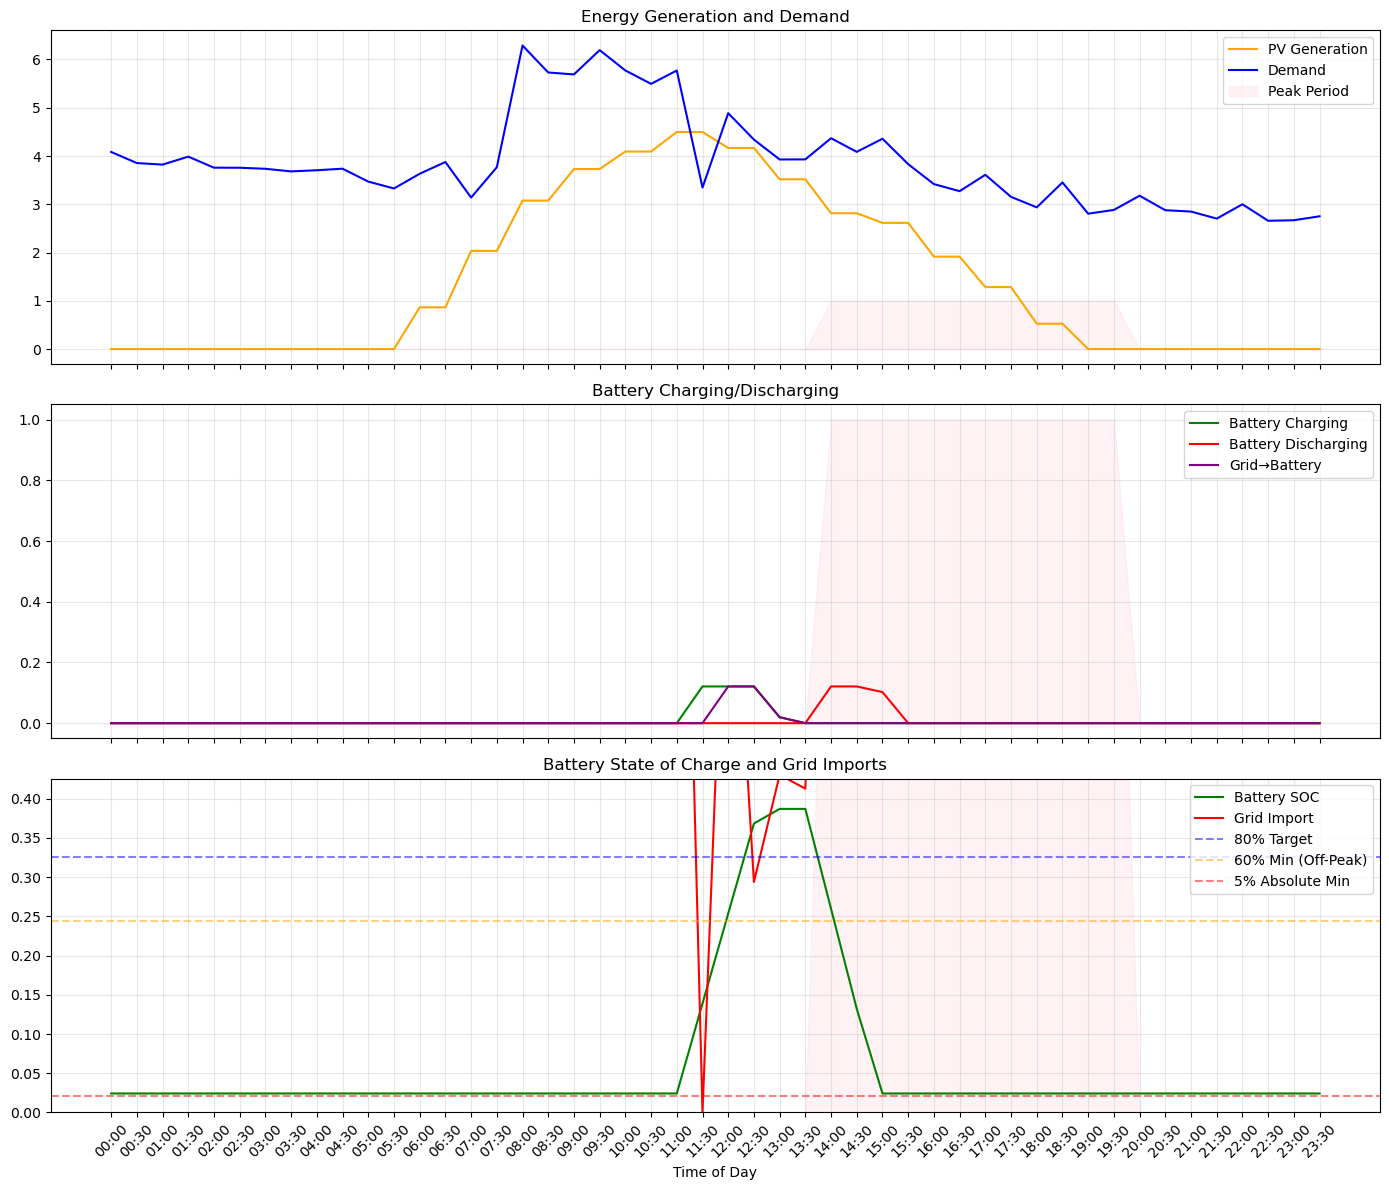

Daily Summary for 2025-01-15:
Total PV Generation: 70.27 kWh
Total Demand: 185.56 kWh
Peak Hours: 6.0 hours
Battery Charge: 0.38 kWh
Battery Discharge: 0.34 kWh
Grid-to-Battery Charging: 0.26 kWh
Grid Import (Peak): 23.52 kWh
Grid Import (Off-Peak): 92.85 kWh
PV Export: 1.03 kWh


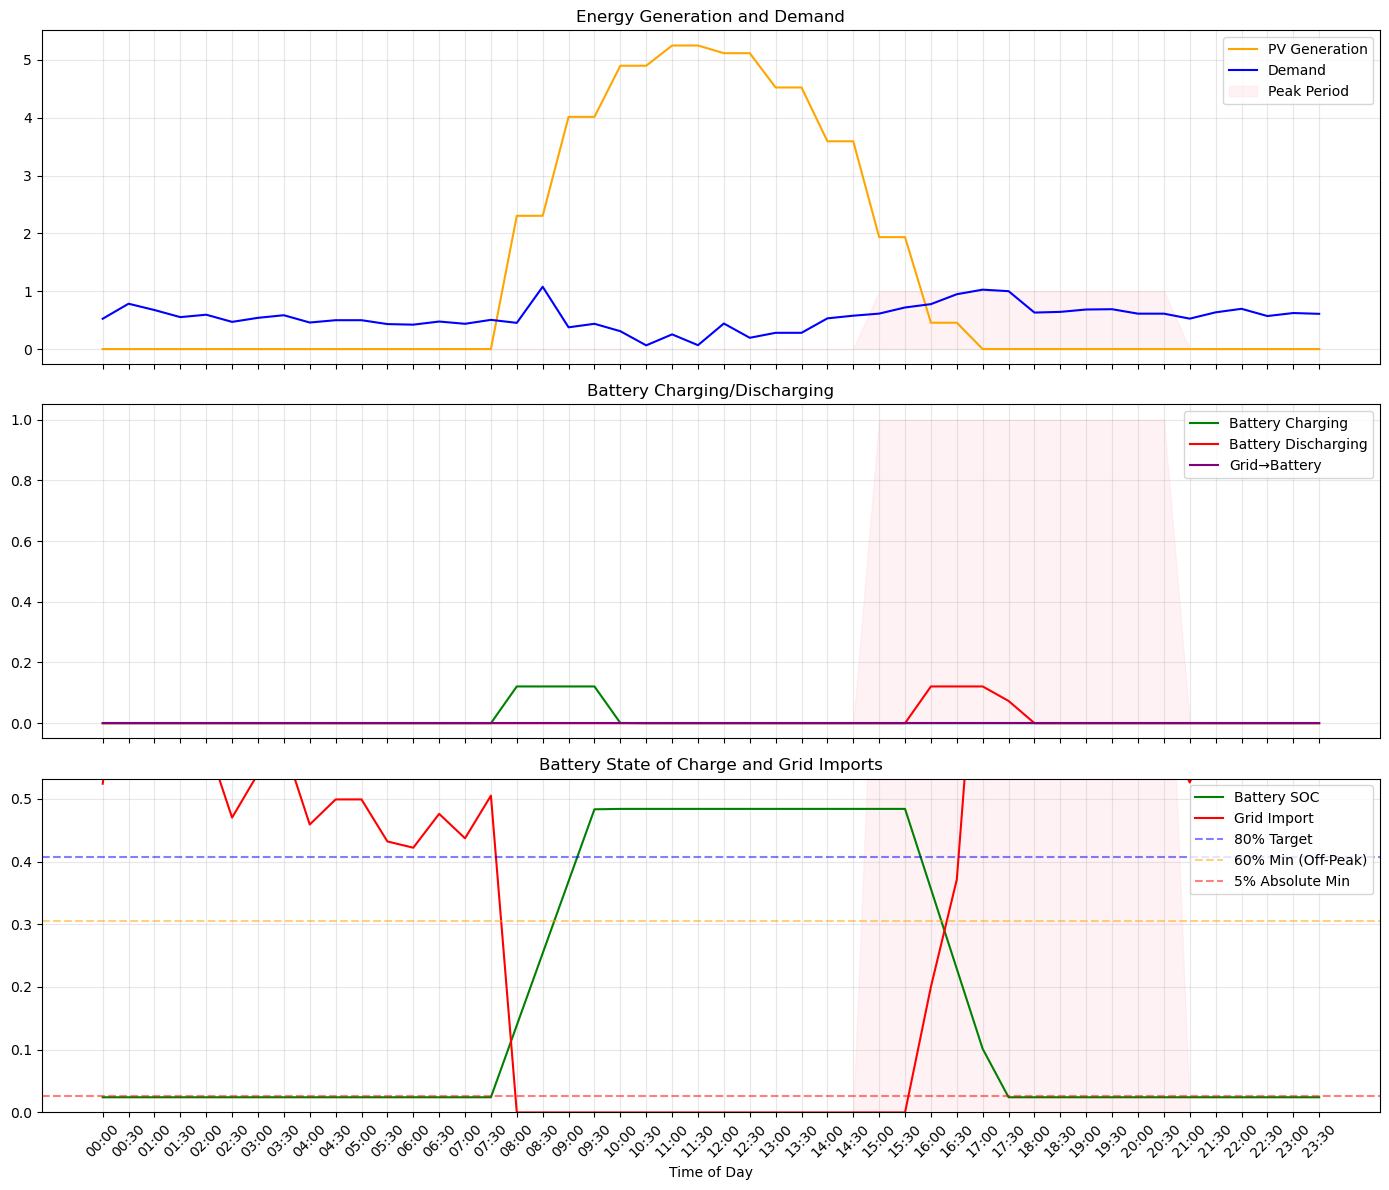

Daily Summary for 2025-07-15:
Total PV Generation: 64.18 kWh
Total Demand: 26.41 kWh
Peak Hours: 6.0 hours
Battery Charge: 0.48 kWh
Battery Discharge: 0.44 kWh
Grid-to-Battery Charging: 0.00 kWh
Grid Import (Peak): 6.28 kWh
Grid Import (Off-Peak): 12.11 kWh
PV Export: 56.10 kWh


In [20]:
# Cell 13: Detailed simulation of best IRR solution
print("\nRunning detailed simulation for best IRR solution...")
start_time = time.time()

# Define base electricity rates (add these lines)
BASE_PEAK_RATE = 0.39710    # Peak electricity rate ($/kWh)
BASE_OFFPEAK_RATE = 0.13530 # Off-peak electricity rate ($/kWh)

# Create detailed configuration for best IRR solution
best_irr_battery = df.loc[best_irr_idx, 'battery_kwh']
best_irr_pv = df.loc[best_irr_idx, 'additional_pv_kw']

print(f"Simulating with {best_irr_battery:.2f} kWh battery and {best_irr_pv:.2f} kW additional PV...")

# Configure base PV and additional PV
allocated_pv = allocate_pv_capacity(best_irr_pv, pv_options)
all_pv = [existing_pv.copy()] + allocated_pv

# Simulate PV generation
combined_pv = simulate_multi_year_pv(
    weather_files=weather_files,
    roof_params=all_pv,
    repeats_per_file=10,
    start_years=start_years
)

# Simulate battery dispatch
print(f"Simulating battery dispatch with peak/off-peak awareness...")
best_irr_dispatch, best_irr_totals = simulate_battery_dispatch(
    pv_gen=combined_pv['simulated_kwh'],
    demand=demand_profile,
    battery_kwh=best_irr_battery,
    battery_kw=best_irr_battery * 0.5,  # 0.5C power rating
    roundtrip_eff=0.9,                  # 90% round trip efficiency
    min_soc_pct=0.05,                   # 5% minimum SOC (95% DoD)
    annual_deg_rate=0.01,               # 1% capacity fade per year (linear simplification)
    grid_emission_rate=0.79,            # 0.79 kg CO2e/kWh
    peak_reserve_soc=0.8,               # 80% SOC reserved for peak
    peak_reserve_hours=2,               # Start reserving within 2h of peak 
    off_peak_min_soc=0.6                # 60% minimum SOC during off-peak
)

# Display detailed results
elapsed = time.time() - start_time
print(f"Simulation completed in {elapsed:.1f} seconds")
print("\nDetailed Results for Best IRR Solution:")
print(f"Battery Size: {best_irr_battery:.2f} kWh")
print(f"Additional PV: {best_irr_pv:.2f} kW")
print(f"Total PV Capacity: {existing_pv['system_capacity_kw'] + best_irr_pv:.2f} kW")
print(f"IRR: {df.loc[best_irr_idx, 'IRR']*100:.2f}%")
print(f"NPV: ${df.loc[best_irr_idx, 'NPV']:,.2f}")

print("\nEnergy Flow Totals (30 years):")
print(f"Total Demand: {best_irr_totals['total_demand']:,.2f} kWh")
print(f"PV Used Directly: {best_irr_totals['total_pv_used']:,.2f} kWh ({best_irr_totals['total_pv_used']/best_irr_totals['total_demand']*100:.1f}%)")
print(f"Battery Discharge: {best_irr_totals['total_battery_discharge']:,.2f} kWh ({best_irr_totals['total_battery_discharge']/best_irr_totals['total_demand']*100:.1f}%)")
print(f"Grid Import (Peak): {best_irr_totals['total_grid_import_peak']:,.2f} kWh")
print(f"Grid Import (Off-Peak): {best_irr_totals['total_grid_import_offpeak']:,.2f} kWh")
print(f"Total Grid Import: {best_irr_totals['total_grid_import_peak'] + best_irr_totals['total_grid_import_offpeak']:,.2f} kWh")
print(f"PV Export: {best_irr_totals['total_pv_export']:,.2f} kWh")

print("\nBattery Performance:")
print(f"Battery Cycles: {best_irr_totals['battery_cycles']:.1f}")
print(f"Final Degradation: {best_irr_totals['final_degradation_pct']:.1f}%")
print(f"Renewable Fraction: {best_irr_totals['renewable_fraction']*100:.1f}%")
print(f"Self-Consumption Rate: {best_irr_totals['self_consumption_rate']*100:.1f}%")

print("\nPeak Shifting Analysis:")
print(f"Peak Hours: {best_irr_totals['peak_hours']:,.1f} hours")
print(f"Off-Peak Hours: {best_irr_totals['offpeak_hours']:,.1f} hours")
print(f"Battery Discharge During Peak: {best_irr_totals['peak_discharge_kwh']:,.2f} kWh")
print(f"Battery Discharge During Off-Peak: {best_irr_totals['offpeak_discharge_kwh']:,.2f} kWh")
print(f"Grid-to-Battery Charging: {best_irr_totals['total_grid_to_battery']:,.2f} kWh")
print(f"  During Peak: {best_irr_totals['peak_grid_to_battery']:,.2f} kWh")
print(f"  During Off-Peak: {best_irr_totals['offpeak_grid_to_battery']:,.2f} kWh")
print(f"Peak Demand Supplied by Battery: {best_irr_totals['peak_pct_supplied_by_battery']*100:.1f}%")

# Calculate financial benefit of peak shifting
annual_offpeak_charge_cost = best_irr_totals['offpeak_grid_to_battery'] * BASE_OFFPEAK_RATE / 30
annual_peak_discharge_value = best_irr_totals['offpeak_grid_to_battery'] * 0.9 * BASE_PEAK_RATE / 30
annual_arbitrage_benefit = annual_peak_discharge_value - annual_offpeak_charge_cost
print(f"\nAnnual Peak-Shifting Financial Benefit: ${annual_arbitrage_benefit:.2f}/year")
print(f"30-year Present Value of Peak-Shifting: ${calculate_present_value(annual_arbitrage_benefit, 0.07):.2f}")

# Save dispatch data to CSV for further analysis
best_irr_dispatch.to_csv(run_dir / 'best_irr_dispatch.csv')
print(f"✅ Dispatch data saved to {run_dir/'best_irr_dispatch.csv'}")

# Create daily profile visualizations
print("\nCreating daily profile visualizations...")
summer_day = '2025-01-15'  # Mid-summer in Southern Hemisphere
winter_day = '2025-07-15'  # Mid-winter in Southern Hemisphere

visualize_battery_operation(best_irr_dispatch, summer_day, run_dir / 'best_irr_summer_day.png')
visualize_battery_operation(best_irr_dispatch, winter_day, run_dir / 'best_irr_winter_day.png')

In [21]:
# Add Battery Diagnostic Functions
def visualize_battery_operation(dispatch_df, date_str, output_file=None):
    """Create a diagnostic visualization of battery operation for a single day"""
    # Extract data for the specified date
    day_data = dispatch_df[dispatch_df.index.date == pd.Timestamp(date_str).date()]
    
    if len(day_data) == 0:
        print(f"No data available for {date_str}")
        return
    
    # Create plot
    fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
    
    # Energy flows
    ax1 = axes[0]
    ax1.plot(day_data.index.strftime('%H:%M'), day_data['pv_gen'], 'orange', label='PV Generation')
    ax1.plot(day_data.index.strftime('%H:%M'), day_data['demand'], 'blue', label='Demand')
    ax1.fill_between(day_data.index.strftime('%H:%M'), 0, day_data['is_peak'], alpha=0.2, color='pink', label='Peak Period')
    ax1.set_title('Energy Generation and Demand')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Battery charging/discharging
    ax2 = axes[1]
    ax2.plot(day_data.index.strftime('%H:%M'), day_data['battery_charge'], 'green', label='Battery Charging')
    ax2.plot(day_data.index.strftime('%H:%M'), day_data['battery_discharge'], 'red', label='Battery Discharging')
    if 'grid_to_battery' in day_data.columns:
        ax2.plot(day_data.index.strftime('%H:%M'), day_data['grid_to_battery'], 'purple', label='Grid→Battery')
    ax2.fill_between(day_data.index.strftime('%H:%M'), 0, day_data['is_peak'], alpha=0.2, color='pink')
    ax2.set_title('Battery Charging/Discharging')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Battery SOC and grid imports
    ax3 = axes[2]
    ax3.plot(day_data.index.strftime('%H:%M'), day_data['battery_soc'], 'green', label='Battery SOC')
    ax3.plot(day_data.index.strftime('%H:%M'), day_data['grid_import_peak'] + day_data['grid_import_offpeak'], 
             'red', label='Grid Import')
    soc_max = day_data['battery_soc'].max() * 1.1  # Add some headroom
    ax3.set_ylim(0, soc_max)
    
    # Add target SOC lines
    if 'battery_soc' in day_data and day_data['battery_soc'].max() > 0:
        capacity = day_data['battery_soc'].max() / 0.95  # Estimate capacity from max SOC
        ax3.axhline(y=capacity * 0.8, color='blue', linestyle='--', alpha=0.5, label='80% Target')
        ax3.axhline(y=capacity * 0.6, color='orange', linestyle='--', alpha=0.5, label='60% Min (Off-Peak)')
        ax3.axhline(y=capacity * 0.05, color='red', linestyle='--', alpha=0.5, label='5% Absolute Min')
    
    ax3.fill_between(day_data.index.strftime('%H:%M'), 0, day_data['is_peak'], alpha=0.2, color='pink')
    ax3.set_title('Battery State of Charge and Grid Imports')
    ax3.set_xlabel('Time of Day')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Rotate x-axis labels for better readability
    for ax in axes:
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    
    if output_file:
        plt.savefig(output_file, dpi=300)
    
    plt.show()
    
    # Print summary statistics
    print(f"Daily Summary for {date_str}:")
    print(f"Total PV Generation: {day_data['pv_gen'].sum():.2f} kWh")
    print(f"Total Demand: {day_data['demand'].sum():.2f} kWh")
    print(f"Peak Hours: {day_data['is_peak'].sum() * 0.5:.1f} hours")
    print(f"Battery Charge: {day_data['battery_charge'].sum():.2f} kWh")
    print(f"Battery Discharge: {day_data['battery_discharge'].sum():.2f} kWh")
    if 'grid_to_battery' in day_data.columns:
        print(f"Grid-to-Battery Charging: {day_data['grid_to_battery'].sum():.2f} kWh")
    print(f"Grid Import (Peak): {day_data['grid_import_peak'].sum():.2f} kWh")
    print(f"Grid Import (Off-Peak): {day_data['grid_import_offpeak'].sum():.2f} kWh")
    print(f"PV Export: {day_data['pv_export'].sum():.2f} kWh")

# Helper function for financial analysis
def calculate_present_value(annual_amount, discount_rate, years=30, escalation_rate=0.03):
    """Calculate present value of an escalating annual amount."""
    total_pv = 0
    for year in range(years):
        escalated_amount = annual_amount * (1 + escalation_rate)**year
        present_value = escalated_amount / (1 + discount_rate)**(year+1)
        total_pv += present_value
    return total_pv

In [22]:
# Cell 14: Create daily profile plots
# In Cell 14
if 'best_irr_dispatch' not in locals() or best_irr_dispatch is None:
    raise ValueError("best_irr_dispatch not defined. Please run Cell 13 first.")
print("\nCreating daily profile plots...")

print("\nCreating daily profile plots...")

# Summer day
summer_date = pd.Timestamp(f"{demand_profile.index[0].year}-01-15")
summer_mask = (best_irr_dispatch.index.date == summer_date.date())
summer_data = best_irr_dispatch[summer_mask]

plt.figure(figsize=(12, 6))
plt.plot(summer_data.index.strftime('%H:%M'), summer_data['pv_gen'], 'orange', label='PV Generation')
plt.plot(summer_data.index.strftime('%H:%M'), summer_data['demand'], 'blue', label='Demand')
plt.plot(summer_data.index.strftime('%H:%M'), summer_data['battery_discharge'], 'green', label='Battery Discharge')
plt.plot(summer_data.index.strftime('%H:%M'), summer_data['grid_import_peak'] + summer_data['grid_import_offpeak'], 'red', label='Grid Import')
plt.fill_between(summer_data.index.strftime('%H:%M'), summer_data['battery_soc'], alpha=0.3, color='green', label='Battery SOC')
plt.xticks(rotation=90)
plt.title(f'Summer Day Profile: {summer_date.strftime("%B %d")}')
plt.xlabel('Time of Day')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.tight_layout()
plt.savefig(run_dir / "summer_day_profile.png", dpi=300)
plt.close()

# Winter day
winter_date = pd.Timestamp(f"{demand_profile.index[0].year}-07-15")
winter_mask = (best_irr_dispatch.index.date == winter_date.date())
winter_data = best_irr_dispatch[winter_mask]

plt.figure(figsize=(12, 6))
plt.plot(winter_data.index.strftime('%H:%M'), winter_data['pv_gen'], 'orange', label='PV Generation')
plt.plot(winter_data.index.strftime('%H:%M'), winter_data['demand'], 'blue', label='Demand')
plt.plot(winter_data.index.strftime('%H:%M'), winter_data['battery_discharge'], 'green', label='Battery Discharge')
plt.plot(winter_data.index.strftime('%H:%M'), winter_data['grid_import_peak'] + winter_data['grid_import_offpeak'], 'red', label='Grid Import')
plt.fill_between(winter_data.index.strftime('%H:%M'), winter_data['battery_soc'], alpha=0.3, color='green', label='Battery SOC')
plt.xticks(rotation=90)
plt.title(f'Winter Day Profile: {winter_date.strftime("%B %d")}')
plt.xlabel('Time of Day')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.tight_layout()
plt.savefig(run_dir / "winter_day_profile.png", dpi=300)
plt.close()

print(f"✅ Daily profile plots saved to {run_dir}")


Creating daily profile plots...

Creating daily profile plots...
✅ Daily profile plots saved to /Users/petertunali/Documents/GitHub/Battery_Optimisation/5_nsga/5_nsga_scripts_master/5_nsga_results/011


In [23]:
# Cell 14.2: Create daily profile plots for best NPV solution
print("\nRunning detailed simulation for best NPV solution...")
start_time = time.time()

# Create detailed configuration for best NPV solution
best_npv_battery = df.loc[best_npv_idx, 'battery_kwh']
best_npv_pv = df.loc[best_npv_idx, 'additional_pv_kw']
best_npv_allocated_pv = allocate_pv_capacity(best_npv_pv, pv_options)

# Add existing PV
best_npv_all_pv = [existing_pv.copy()]
for pv_config in best_npv_allocated_pv:
    if pv_config['system_capacity_kw'] > 0:
        best_npv_all_pv.append(pv_config)

# Simulate combined PV profile
best_npv_pv_profile = simulate_multi_year_pv(
    weather_files=weather_files,
    roof_params=best_npv_all_pv,
    repeats_per_file=10,
    start_years=start_years
)

# Simulate battery dispatch
best_npv_dispatch, best_npv_totals = simulate_battery_dispatch(
    pv_gen=best_npv_pv_profile['simulated_kwh'],
    demand=demand_profile,
    battery_kwh=best_npv_battery,
    battery_kw=best_npv_battery * 0.5,
    roundtrip_eff=0.9,
    min_soc_pct=0.05,
    annual_deg_rate=0.01,
    grid_emission_rate=0.79
)

elapsed = time.time() - start_time
print(f"Best NPV solution simulation completed in {elapsed:.1f} seconds ({timedelta(seconds=int(elapsed))})")

# Create daily profile plots
print("\nCreating daily profile plots for best NPV solution...")
# Summer day
summer_date = pd.Timestamp(f"{demand_profile.index[0].year}-01-15")
summer_mask = (best_npv_dispatch.index.date == summer_date.date())
summer_data = best_npv_dispatch[summer_mask]
plt.figure(figsize=(12, 6))
plt.plot(summer_data.index.strftime('%H:%M'), summer_data['pv_gen'], 'orange', label='PV Generation')
plt.plot(summer_data.index.strftime('%H:%M'), summer_data['demand'], 'blue', label='Demand')
plt.plot(summer_data.index.strftime('%H:%M'), summer_data['battery_discharge'], 'green', label='Battery Discharge')
plt.plot(summer_data.index.strftime('%H:%M'), summer_data['grid_import_peak'] + summer_data['grid_import_offpeak'], 'red', label='Grid Import')
plt.fill_between(summer_data.index.strftime('%H:%M'), summer_data['battery_soc'], alpha=0.3, color='green', label='Battery SOC')
plt.xticks(rotation=90)
plt.title(f'Best NPV Solution - Summer Day Profile: {summer_date.strftime("%B %d")}')
plt.xlabel('Time of Day')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.tight_layout()
plt.savefig(run_dir / "best_npv_summer_day_profile.png", dpi=300)
plt.close()

# Winter day
winter_date = pd.Timestamp(f"{demand_profile.index[0].year}-07-15")
winter_mask = (best_npv_dispatch.index.date == winter_date.date())
winter_data = best_npv_dispatch[winter_mask]
plt.figure(figsize=(12, 6))
plt.plot(winter_data.index.strftime('%H:%M'), winter_data['pv_gen'], 'orange', label='PV Generation')
plt.plot(winter_data.index.strftime('%H:%M'), winter_data['demand'], 'blue', label='Demand')
plt.plot(winter_data.index.strftime('%H:%M'), winter_data['battery_discharge'], 'green', label='Battery Discharge')
plt.plot(winter_data.index.strftime('%H:%M'), winter_data['grid_import_peak'] + winter_data['grid_import_offpeak'], 'red', label='Grid Import')
plt.fill_between(winter_data.index.strftime('%H:%M'), winter_data['battery_soc'], alpha=0.3, color='green', label='Battery SOC')
plt.xticks(rotation=90)
plt.title(f'Best NPV Solution - Winter Day Profile: {winter_date.strftime("%B %d")}')
plt.xlabel('Time of Day')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.tight_layout()
plt.savefig(run_dir / "best_npv_winter_day_profile.png", dpi=300)
plt.close()

# Save NPV solution details
npv_summary = {
    'total_pv_capacity_kw': existing_pv['system_capacity_kw'] + best_npv_pv,
    'additional_pv_capacity_kw': best_npv_pv,
    'battery_capacity_kwh': best_npv_battery,
    'irr': df.loc[best_npv_idx, 'IRR'],
    'npv': df.loc[best_npv_idx, 'NPV'],
    'renewable_fraction': best_npv_totals['renewable_fraction'],
    'self_consumption_rate': best_npv_totals['self_consumption_rate'],
    'grid_emissions': best_npv_totals['total_grid_emissions'],
    'battery_cycles': best_npv_totals['battery_cycles'],
    'battery_degradation': best_npv_totals['final_degradation_pct']
}
pd.DataFrame([npv_summary]).to_csv(run_dir / 'best_npv_summary.csv', index=False)
print(f"✅ Best NPV solution details saved to {run_dir/'best_npv_summary.csv'}")
print(f"✅ Best NPV daily profile plots saved to {run_dir}")


Running detailed simulation for best NPV solution...
Best NPV solution simulation completed in 2.2 seconds (0:00:02)

Creating daily profile plots for best NPV solution...
✅ Best NPV solution details saved to /Users/petertunali/Documents/GitHub/Battery_Optimisation/5_nsga/5_nsga_scripts_master/5_nsga_results/011/best_npv_summary.csv
✅ Best NPV daily profile plots saved to /Users/petertunali/Documents/GitHub/Battery_Optimisation/5_nsga/5_nsga_scripts_master/5_nsga_results/011


Testing with 2x peak rate...

🔍 TESTING RATE STRUCTURE SENSITIVITY
Original rates: Peak $0.39710/kWh, Off-Peak $0.13530/kWh
Test rates: Peak $0.79420/kWh, Off-Peak $0.13530/kWh
Peak/Off-Peak ratio: 5.87x

Testing 5 kWh battery...
  IRR: 0.00%
  NPV: $-42,344.28
  Grid-to-Battery: 30891.90 kWh
  Annual Arbitrage Benefit: $589.02

Testing 10 kWh battery...
  IRR: 0.00%
  NPV: $-32,360.29
  Grid-to-Battery: 78708.66 kWh
  Annual Arbitrage Benefit: $1507.80

Testing 20 kWh battery...
  IRR: -0.03%
  NPV: $-20,470.95
  Grid-to-Battery: 143504.42 kWh
  Annual Arbitrage Benefit: $2745.91

SUMMARY OF RATE SENSITIVITY TEST:
Peak rate: $0.79420/kWh, Off-Peak rate: $0.13530/kWh (Ratio: 5.87x)
--------------------------------------------------------------------------------
Battery Size | IRR (%)  |   NPV ($)    | Grid→Batt (kWh)  | Annual Benefit
--------------------------------------------------------------------------------
    5.0      |   0.00   |   -42,344    |     30,891.9     | $   589.02  

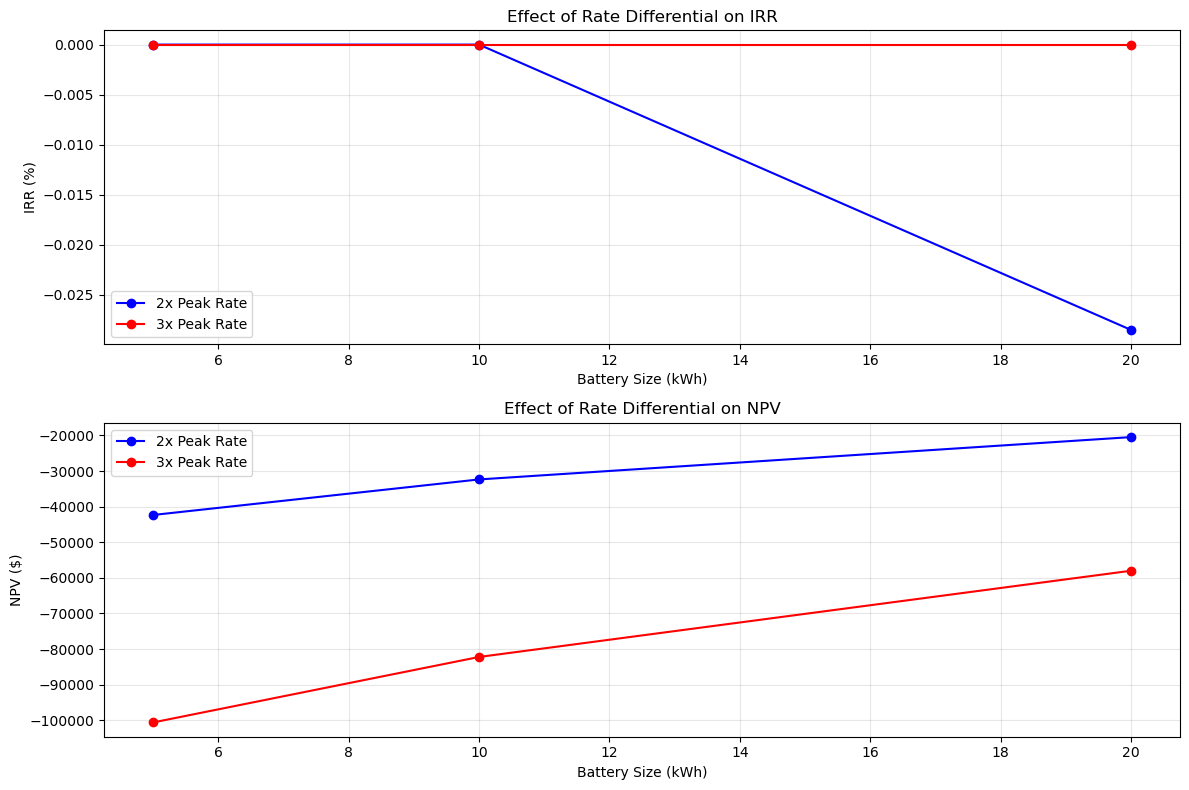

✅ Rate sensitivity analysis completed and saved to /Users/petertunali/Documents/GitHub/Battery_Optimisation/5_nsga/5_nsga_scripts_master/5_nsga_results/011/rate_sensitivity_analysis.png


In [24]:
# Cell for testing different rate structures
def test_different_rate_structure(peak_rate_multiplier=2.0, off_peak_rate_multiplier=1.0):
    """Run a test with different peak/off-peak rate differentials"""
    # Save original rates
    original_peak_rate = obj.BASE_PEAK_RATE
    original_offpeak_rate = obj.BASE_OFFPEAK_RATE
    
    # Set new rates
    test_peak_rate = original_peak_rate * peak_rate_multiplier
    test_offpeak_rate = original_offpeak_rate * off_peak_rate_multiplier
    
    print(f"\n🔍 TESTING RATE STRUCTURE SENSITIVITY")
    print(f"Original rates: Peak ${original_peak_rate:.5f}/kWh, Off-Peak ${original_offpeak_rate:.5f}/kWh")
    print(f"Test rates: Peak ${test_peak_rate:.5f}/kWh, Off-Peak ${test_offpeak_rate:.5f}/kWh")
    print(f"Peak/Off-Peak ratio: {test_peak_rate/test_offpeak_rate:.2f}x")
    
    # Update the rates in obj module
    obj.BASE_PEAK_RATE = test_peak_rate
    obj.BASE_OFFPEAK_RATE = test_offpeak_rate
    
    # Test battery sizes to try
    test_sizes = [5, 10, 20]
    
    results = []
    for batt_kwh in test_sizes:
        print(f"\nTesting {batt_kwh} kWh battery...")
        
        # Test with simple additional PV (10 kW)
        pv_kw = 10.0
        
        # Configure base PV and additional PV
        allocated_pv = allocate_pv_capacity(pv_kw, pv_options)
        all_pv = [existing_pv.copy()]
        for pv_config in allocated_pv:
            if pv_config['system_capacity_kw'] > 0:
                all_pv.append(pv_config)
        
        # Simulate PV generation
        combined_pv = simulate_multi_year_pv(
            weather_files=weather_files,
            roof_params=all_pv,
            repeats_per_file=10,
            start_years=start_years
        )
        
        # Simulate battery dispatch
        dispatch, totals = simulate_battery_dispatch(
            pv_gen=combined_pv['simulated_kwh'],
            demand=demand_profile,
            battery_kwh=batt_kwh,
            battery_kw=batt_kwh * 0.5,  # 0.5C power rating
            roundtrip_eff=0.9,
            min_soc_pct=0.05,
            annual_deg_rate=0.01,
            grid_emission_rate=0.79,
            peak_reserve_soc=0.8,
            peak_reserve_hours=2,
            off_peak_min_soc=0.6
        )
        
        # Run financial analysis
        params = {
            'battery_kwh': batt_kwh,
            'additional_pv_kw': pv_kw
        }
        
        # Get financial results
        result = evaluate_solution(params, combined_pv, demand_profile)
        irr = -result[0]  # Get actual IRR (not negative)
        npv = -result[1]  # Get actual NPV (not negative)
        
        # Calculate financial benefit of peak shifting
        annual_offpeak_charge_cost = totals['offpeak_grid_to_battery'] * test_offpeak_rate / 30
        annual_peak_discharge_value = totals['offpeak_grid_to_battery'] * 0.9 * test_peak_rate / 30
        annual_arbitrage_benefit = annual_peak_discharge_value - annual_offpeak_charge_cost
        
        # Store results
        results.append({
            'battery_kwh': batt_kwh,
            'additional_pv_kw': pv_kw,
            'irr': irr * 100,  # Convert to percentage
            'npv': npv,
            'total_grid_to_battery': totals['total_grid_to_battery'],
            'offpeak_grid_to_battery': totals['offpeak_grid_to_battery'],
            'peak_grid_to_battery': totals['peak_grid_to_battery'],
            'peak_discharge_kwh': totals['peak_discharge_kwh'],
            'annual_arbitrage_benefit': annual_arbitrage_benefit
        })
        
        print(f"  IRR: {irr*100:.2f}%")
        print(f"  NPV: ${npv:,.2f}")
        print(f"  Grid-to-Battery: {totals['total_grid_to_battery']:.2f} kWh")
        print(f"  Annual Arbitrage Benefit: ${annual_arbitrage_benefit:.2f}")
    
    # Restore original rates
    obj.BASE_PEAK_RATE = original_peak_rate
    obj.BASE_OFFPEAK_RATE = original_offpeak_rate
    
    # Print summary table
    print("\nSUMMARY OF RATE SENSITIVITY TEST:")
    print(f"Peak rate: ${test_peak_rate:.5f}/kWh, Off-Peak rate: ${test_offpeak_rate:.5f}/kWh (Ratio: {test_peak_rate/test_offpeak_rate:.2f}x)")
    print("-" * 80)
    print(f"{'Battery Size':^12} | {'IRR (%)':^8} | {'NPV ($)':^12} | {'Grid→Batt (kWh)':^16} | {'Annual Benefit':^14}")
    print("-" * 80)
    
    for r in results:
        print(f"{r['battery_kwh']:^12.1f} | {r['irr']:^8.2f} | {r['npv']:^12,.0f} | {r['total_grid_to_battery']:^16,.1f} | ${r['annual_arbitrage_benefit']:^13,.2f}")
    
    print("-" * 80)
    return results

# Run tests with different rate structures
print("Testing with 2x peak rate...")
results_2x = test_different_rate_structure(peak_rate_multiplier=2.0)

print("\nTesting with 3x peak rate...")
results_3x = test_different_rate_structure(peak_rate_multiplier=3.0)

# Create a visualization of the results
plt.figure(figsize=(12, 8))

# Plot IRR comparison
plt.subplot(2, 1, 1)
battery_sizes = [r['battery_kwh'] for r in results_2x]
irr_2x = [r['irr'] for r in results_2x]
irr_3x = [r['irr'] for r in results_3x]

plt.plot(battery_sizes, irr_2x, 'b-o', label='2x Peak Rate')
plt.plot(battery_sizes, irr_3x, 'r-o', label='3x Peak Rate')
plt.xlabel('Battery Size (kWh)')
plt.ylabel('IRR (%)')
plt.title('Effect of Rate Differential on IRR')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot NPV comparison
plt.subplot(2, 1, 2)
npv_2x = [r['npv'] for r in results_2x]
npv_3x = [r['npv'] for r in results_3x]

plt.plot(battery_sizes, npv_2x, 'b-o', label='2x Peak Rate')
plt.plot(battery_sizes, npv_3x, 'r-o', label='3x Peak Rate')
plt.xlabel('Battery Size (kWh)')
plt.ylabel('NPV ($)')
plt.title('Effect of Rate Differential on NPV')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig(run_dir / 'rate_sensitivity_analysis.png', dpi=300)
plt.show()

print(f"✅ Rate sensitivity analysis completed and saved to {run_dir/'rate_sensitivity_analysis.png'}")

In [27]:
# Cell 16: Comprehensive Financial Analysis for both Best IRR and Best NPV Solutions
print("\nPerforming comprehensive financial analysis for both Best IRR and Best NPV solutions...")

# Import the required functions from fin.py
from fin import calculate_lcoe

# Define discount rate here at the beginning
discount_rate = 0.07  # 7% discount rate

# Print solution details
print(f"\nAnalyzing Best IRR solution: {best_irr_battery:.2f} kWh battery and {best_irr_pv:.2f} kW additional PV")
print(f"Analyzing Best NPV solution: {best_npv_battery:.2f} kWh battery and {best_npv_pv:.2f} kW additional PV")

# Function to perform financial analysis for a solution
def analyze_solution(solution_name, battery_kwh, additional_pv_kw, solution_idx):
    # Add maintenance inflation rate
    maintenance_inflation_rate = 0.03  # 3% annual inflation for maintenance (same as escalation)
    
    print(f"\n{'-'*80}")
    print(f"{solution_name} SOLUTION ANALYSIS:")
    print(f"Battery: {battery_kwh:.2f} kWh, Additional PV: {additional_pv_kw:.2f} kW")
    print(f"{'-'*80}")
    
    # Create a new dataframe for the financial summary
    fin_summary = {
        'metric': [],
        'value': [],
        'unit': [],
        'description': []
    }

    # Add basic system information
    fin_summary['metric'].extend(['total_pv_capacity', 'additional_pv_capacity', 'battery_capacity'])
    fin_summary['value'].extend([
        existing_pv['system_capacity_kw'] + additional_pv_kw,
        additional_pv_kw,
        battery_kwh
    ])
    fin_summary['unit'].extend(['kW', 'kW', 'kWh'])
    fin_summary['description'].extend([
        'Total PV system capacity (existing + additional)',
        'Additional PV capacity beyond existing system',
        'Battery energy storage capacity'
    ])
    
    # Simulate this solution
    allocated_pv = allocate_pv_capacity(additional_pv_kw, pv_options)
    all_pv = [existing_pv.copy()]
    for pv_config in allocated_pv:
        if pv_config['system_capacity_kw'] > 0:
            all_pv.append(pv_config)
    
    # Simulate PV profile
    solution_pv_profile = simulate_multi_year_pv(
        weather_files=weather_files,
        roof_params=all_pv,
        repeats_per_file=10,
        start_years=start_years
    )
    
    # Simulate battery dispatch
    solution_dispatch, solution_totals = simulate_battery_dispatch(
        pv_gen=solution_pv_profile['simulated_kwh'],
        demand=demand_profile,
        battery_kwh=battery_kwh,
        battery_kw=battery_kwh * 0.5,
        roundtrip_eff=0.9,
        min_soc_pct=0.05,
        annual_deg_rate=0.01,
        grid_emission_rate=0.79
    )
    
    # Add energy metrics
    fin_summary['metric'].extend([
        'total_demand', 'total_pv_used', 'total_battery_discharge',
        'total_grid_import_peak', 'total_grid_import_offpeak', 'total_pv_export',
        'total_grid_emissions', 'renewable_fraction', 'grid_fraction',
        'self_consumption_rate'
    ])
    fin_summary['value'].extend([
        solution_totals['total_demand'],
        solution_totals['total_pv_used'],
        solution_totals['total_battery_discharge'],
        solution_totals['total_grid_import_peak'],
        solution_totals['total_grid_import_offpeak'],
        solution_totals['total_pv_export'],
        solution_totals['total_grid_emissions'],
        solution_totals['renewable_fraction'],
        1 - solution_totals['renewable_fraction'],
        solution_totals['self_consumption_rate']
    ])
    fin_summary['unit'].extend([
        'kWh', 'kWh', 'kWh', 'kWh', 'kWh', 'kWh', 'kg CO2e', 'fraction', 'fraction', 'fraction'
    ])
    fin_summary['description'].extend([
        'Total electricity demand over 30 years',
        'PV generation used directly to satisfy demand',
        'Energy discharged from battery storage',
        'Grid electricity imported during peak periods',
        'Grid electricity imported during off-peak periods',
        'Excess PV generation exported to grid',
        'CO2 emissions from grid electricity',
        'Fraction of demand met by renewable sources',
        'Fraction of demand met by grid imports',
        'Fraction of PV generation consumed on-site'
    ])

    # Add financial metrics
    fin_summary['metric'].extend([
        'pv_capex', 'battery_capex', 'total_capex',
        'annual_maintenance', 'total_maintenance',
        'npv', 'irr', 'simple_payback', 'lcoe'  # Added LCOE here
    ])

    # Calculate battery cost
    if battery_kwh > 0:
        battery_cost_per_kwh = 977.54 * np.exp(-0.004 * battery_kwh)
        battery_cost_per_kwh = max(600.0, battery_cost_per_kwh)
        battery_capex = battery_kwh * (battery_cost_per_kwh + 174.0)
    else:
        battery_capex = 0

    # Calculate PV capital costs
    pv_capital_cost = 0
    if additional_pv_kw > 0:
        # Calculate costs for each allocated PV component
        for pv_config in allocated_pv:
            capacity = pv_config['system_capacity_kw']
            cost_multiplier = pv_config.get('cost_multiplier', 1.0)
            cost_per_kw = calculate_pv_cost(capacity, cost_multiplier)
            pv_capital_cost += capacity * cost_per_kw
        
        # No fixed installation cost - removed as requested

    annual_maintenance = 250  # $250 per year for PV maintenance
    total_maintenance = annual_maintenance * 30

    fin_summary['value'].extend([
        pv_capital_cost,
        battery_capex,
        pv_capital_cost + battery_capex,
        annual_maintenance,
        total_maintenance,
        df.loc[solution_idx, 'NPV'],
        df.loc[solution_idx, 'IRR'] if pd.notna(df.loc[solution_idx, 'IRR']) else None,
        None,  # Simple payback will be calculated later
        None   # LCOE will be calculated later
    ])

    fin_summary['unit'].extend([
        '$', '$', '$', '$/year', '$', '$', 'fraction', 'years', '$/kWh'  # Added $/kWh
    ])

    fin_summary['description'].extend([
        'Capital cost for additional PV capacity',
        'Capital cost for battery storage',
        'Total capital expenditure',
        'Annual maintenance cost',
        'Total maintenance cost over 30 years',
        'Net Present Value of investment',
        'Internal Rate of Return',
        'Simple payback period against PV-only baseline',
        'Levelized Cost of Energy'  # Added description
    ])

    # Create and save the dataframe
    fin_summary_df = pd.DataFrame(fin_summary)
    fin_summary_df.to_csv(run_dir / f'{solution_name.lower()}_financial_summary.csv', index=False)
    print(f"✅ {solution_name} financial summary saved to {run_dir/f'{solution_name.lower()}_financial_summary.csv'}")

    # Calculate cash flows for incremental analysis
    print(f"\nVerifying incremental financial analysis for {solution_name} solution:")
    print("This analysis compares the proposed system (existing PV + new PV + battery)")
    print(f"against the current baseline (existing PV only - ${ANNUAL_PV_ONLY_COST:,.2f}/year)")

    # Set up escalation for electricity prices
    annual_costs = []
    annual_pv_only_costs = []

    for year in range(30):
        # Apply escalation
        year_escalation = (1 + escalation_rate)**year
        year_peak_rate = base_peak_rate * year_escalation
        year_offpeak_rate = base_offpeak_rate * year_escalation
        year_export_rate = base_export_rate * year_escalation
        
        # Apply inflation to maintenance cost
        year_maintenance = annual_maintenance * (1 + maintenance_inflation_rate)**year
        
        # PV-only baseline (with escalation)
        year_pv_only_cost = ANNUAL_PV_ONLY_COST * year_escalation
        annual_pv_only_costs.append(year_pv_only_cost)
        
        # Proposed system
        # Get annual values (assume equal distribution)
        annual_peak_import = solution_totals['total_grid_import_peak'] / 30
        annual_offpeak_import = solution_totals['total_grid_import_offpeak'] / 30
        annual_export = solution_totals['total_pv_export'] / 30
        
        # Calculate this year's costs
        year_import_cost = annual_peak_import * year_peak_rate + annual_offpeak_import * year_offpeak_rate
        year_export_revenue = annual_export * year_export_rate
        year_net_cost = year_import_cost - year_export_revenue + year_maintenance
        
        annual_costs.append({
            'year': year + 1,
            'escalation_factor': year_escalation,
            'peak_rate': year_peak_rate,
            'offpeak_rate': year_offpeak_rate,
            'export_rate': year_export_rate,
            'import_cost': year_import_cost,
            'export_revenue': year_export_revenue,
            'maintenance': year_maintenance,
            'net_cost': year_net_cost,
            'pv_only_cost': year_pv_only_cost,
            'savings_vs_pv_only': year_pv_only_cost - year_net_cost
        })

    # Calculate NPV
    cash_flows = [-(pv_capital_cost + battery_capex)]  # Initial investment
    for year_data in annual_costs:
        cash_flows.append(year_data['savings_vs_pv_only'])

    # Calculate NPV and IRR
    npv = sum(cf / (1 + discount_rate)**(i) for i, cf in enumerate(cash_flows))
    try:
        # Calculate IRR
        from scipy import optimize
        def npv_func(rate):
            return sum(cf / (1 + rate)**(i) for i, cf in enumerate(cash_flows))
        
        try:
            irr_value = optimize.newton(npv_func, 0.05)
        except:
            try:
                irr_value = optimize.brentq(npv_func, -0.9999, 2.0)
            except:
                irr_value = None
    except:
        irr_value = None
    
    # Calculate simple payback
    if annual_costs[0]['savings_vs_pv_only'] > 0:
        simple_payback = (pv_capital_cost + battery_capex) / annual_costs[0]['savings_vs_pv_only']
    else:
        simple_payback = float('inf')
    
    # Calculate LCOE using imported function
    total_generation = solution_pv_profile['simulated_kwh'].sum()
    lcoe = calculate_lcoe(
        total_generation=total_generation,
        capital_cost=pv_capital_cost + battery_capex,
        annual_maintenance=annual_maintenance,
        maintenance_inflation_rate=maintenance_inflation_rate,
        discount_rate=discount_rate
    )
    
    # Update the financial summary with simple payback and LCOE
    fin_summary_df.loc[fin_summary_df['metric'] == 'simple_payback', 'value'] = simple_payback
    fin_summary_df.loc[fin_summary_df['metric'] == 'lcoe', 'value'] = lcoe
    fin_summary_df.to_csv(run_dir / f'{solution_name.lower()}_financial_summary.csv', index=False)

    # Print verification details
    print(f"\nCalculated NPV: ${npv:,.2f}")
    print(f"Calculated IRR: {irr_value*100:.2f}%" if irr_value is not None else "Calculated IRR: N/A")
    print(f"Calculated Simple Payback: {simple_payback:.2f} years" 
          if annual_costs[0]['savings_vs_pv_only'] > 0 else "Calculated Simple Payback: N/A (no positive savings)")
    print(f"Calculated LCOE: ${lcoe:.5f}/kWh")

    # Show first few years of cash flow
    print(f"\n{solution_name} Incremental Cash Flow Analysis (first 5 years):")
    print("Year | Proposed System | PV-Only Baseline | Savings | Discounted Savings | Cumulative NPV")
    print("----|----------------|-----------------|---------|-------------------|---------------")

    cumulative_npv = cash_flows[0]  # Start with initial investment
    print(f"   0 | ${0:13,.2f} | ${0:15,.2f} | ${cash_flows[0]:7,.2f} | ${cash_flows[0]:17,.2f} | ${cumulative_npv:13,.2f}")

    for i, year_data in enumerate(annual_costs[:5]):  # Show first 5 years
        year = i + 1
        disc_savings = year_data['savings_vs_pv_only'] / (1 + discount_rate)**year
        cumulative_npv += disc_savings
        
        print(f"{year:4d} | ${year_data['net_cost']:13,.2f} | ${year_data['pv_only_cost']:15,.2f} | " +
              f"${year_data['savings_vs_pv_only']:7,.2f} | ${disc_savings:17,.2f} | ${cumulative_npv:13,.2f}")

    # Save the detailed cash flow
    annual_costs_df = pd.DataFrame(annual_costs)
    annual_costs_df.to_csv(run_dir / f'{solution_name.lower()}_annual_cash_flows.csv', index=False)
    print(f"\n✅ Detailed annual cash flows saved to {run_dir/f'{solution_name.lower()}_annual_cash_flows.csv'}")

    # Create a text file summary
    with open(run_dir / f'{solution_name.lower()}_financial_analysis.txt', 'w') as f:
        f.write(f"{'='*47}\n")
        f.write(f"{solution_name} SOLUTION FINANCIAL ANALYSIS\n")
        f.write(f"{'='*47}\n\n")
        
        f.write("SYSTEM CONFIGURATION\n")
        f.write("-------------------\n")
        f.write(f"Existing PV Capacity: {existing_pv['system_capacity_kw']:.2f} kW\n")
        f.write(f"Additional PV Capacity: {additional_pv_kw:.2f} kW\n")
        f.write(f"Total System PV Capacity: {existing_pv['system_capacity_kw'] + additional_pv_kw:.2f} kW\n")
        f.write(f"Battery Size: {battery_kwh:.2f} kWh\n")
        f.write(f"Battery Power: {battery_kwh * 0.5:.2f} kW (0.5C rate)\n\n")
        
        f.write("PV ALLOCATION\n")
        f.write("------------\n")
        f.write(f"Existing System: {existing_pv['system_capacity_kw']:.2f} kW\n")
        for pv_config in allocated_pv:
            f.write(f"{pv_config['name']}: {pv_config['system_capacity_kw']:.2f} kW\n")
            f.write(f"  Tilt: {pv_config['tilt']}°, Azimuth: {pv_config['azimuth']}°, Shading: {pv_config['shading']}%\n")
        f.write("\n")
        
        f.write("FINANCIAL RESULTS\n")
        f.write("-----------------\n")
        f.write(f"PV Capital Cost: ${pv_capital_cost:,.2f}\n")
        f.write(f"Battery Capital Cost: ${battery_capex:,.2f}\n")
        f.write(f"Total Capital Cost: ${pv_capital_cost + battery_capex:,.2f}\n")
        f.write(f"Annual PV Maintenance: ${annual_maintenance:,.2f} (with {maintenance_inflation_rate*100:.1f}% annual inflation)\n")
        f.write(f"IRR: {irr_value*100:.2f}%\n" if irr_value is not None else "IRR: N/A\n")
        f.write(f"NPV: ${npv:,.2f}\n")
        if annual_costs[0]['savings_vs_pv_only'] > 0:
            f.write(f"Simple Payback: {simple_payback:.2f} years\n")
        else:
            f.write(f"Simple Payback: N/A (no positive savings)\n")
        f.write(f"Levelized Cost of Energy (LCOE): ${lcoe:.5f}/kWh\n\n")
        
        f.write("ENERGY RESULTS (30 YEARS)\n")
        f.write("-----------------------\n")
        f.write(f"Total Generation: {solution_pv_profile['simulated_kwh'].sum():,.2f} kWh\n")
        f.write(f"Total Demand: {solution_totals['total_demand']:,.2f} kWh\n")
        f.write(f"PV Self-Consumed: {solution_totals['total_pv_used']:,.2f} kWh\n")
        f.write(f"Battery Discharge: {solution_totals['total_battery_discharge']:,.2f} kWh\n")
        f.write(f"Grid Import: {solution_totals['total_grid_import_peak'] + solution_totals['total_grid_import_offpeak']:,.2f} kWh\n")
        f.write(f"PV Export: {solution_totals['total_pv_export']:,.2f} kWh\n")
        f.write(f"Renewable Fraction: {solution_totals['renewable_fraction']*100:.2f}%\n")
        f.write(f"Self-Consumption Rate: {solution_totals['self_consumption_rate']*100:.2f}%\n")
        f.write(f"Grid Emissions: {solution_totals['total_grid_emissions']:,.2f} kg CO2e\n\n")
        
        f.write("BATTERY PERFORMANCE\n")
        f.write("------------------\n")
        f.write(f"Cycles Over 30 Years: {solution_totals['battery_cycles']:,.2f}\n")
        f.write(f"Final Capacity Degradation: {solution_totals['final_degradation_pct']:.2f}%\n\n")
        
        f.write("INCREMENTAL ANALYSIS VS. PV-ONLY\n")
        f.write("------------------------------\n")
        f.write(f"Current Annual Cost (PV-only): ${ANNUAL_PV_ONLY_COST:,.2f}\n")
        f.write(f"First Year Annual Cost (Proposed): ${annual_costs[0]['net_cost']:,.2f}\n")
        f.write(f"First Year Savings: ${annual_costs[0]['savings_vs_pv_only']:,.2f}\n")
        f.write(f"Total 30-Year Savings (undiscounted): ${sum(year_data['savings_vs_pv_only'] for year_data in annual_costs):,.2f}\n\n")
        
        f.write("NOTES\n")
        f.write("-----\n")
        f.write("- Incremental analysis compares against existing PV-only baseline\n")
        f.write("- Electricity prices escalate at 3% per year\n")
        f.write(f"- Initial electricity rates: Peak = ${base_peak_rate:.5f}/kWh, Off-peak = ${base_offpeak_rate:.5f}/kWh, Export = ${base_export_rate:.5f}/kWh\n")
        f.write("- PV cost calculated using formula: y = 1047.3 * e^(-0.002*x) with minimum $750/kW\n")
        f.write("- Ground-mounted PV has 20% cost premium\n")
        f.write("- Battery cost calculated using formula: y = 977.54 * e^(-0.004*x) with minimum $600/kWh\n")
        f.write("- No battery maintenance costs as per requirements\n")
        f.write(f"- PV maintenance cost: ${annual_maintenance:.2f} per year with {maintenance_inflation_rate*100:.1f}% annual inflation\n")
        f.write("- Discount rate for NPV calculation: 7%\n")

    print(f"✅ Detailed financial analysis saved to {run_dir/f'{solution_name.lower()}_financial_analysis.txt'}")
    
    return {
        'npv': npv,
        'irr': irr_value,
        'simple_payback': simple_payback,
        'lcoe': lcoe,  # Added LCOE to the returned results
        'capex': pv_capital_cost + battery_capex,
        'first_year_savings': annual_costs[0]['savings_vs_pv_only'],
        'total_savings': sum(year_data['savings_vs_pv_only'] for year_data in annual_costs),
        'renewable_fraction': solution_totals['renewable_fraction'],
        'self_consumption_rate': solution_totals['self_consumption_rate'],
        'emissions': solution_totals['total_grid_emissions']
    }

# Analyze Best IRR solution
irr_results = analyze_solution("Best IRR", best_irr_battery, best_irr_pv, best_irr_idx)

# Analyze Best NPV solution
npv_results = analyze_solution("Best NPV", best_npv_battery, best_npv_pv, best_npv_idx)

# Calculate profitability index for each solution
irr_results['profitability_index'] = irr_results['npv'] / irr_results['capex'] if irr_results['capex'] > 0 else float('inf')
npv_results['profitability_index'] = npv_results['npv'] / npv_results['capex'] if npv_results['capex'] > 0 else float('inf')

# Create a comparison table
print("\nCOMPARISON OF BEST IRR AND BEST NPV SOLUTIONS:")
print(f"{'-'*80}")
comparison = pd.DataFrame({
    'Metric': [
        'Battery Size (kWh)',
        'Additional PV (kW)',
        'Total PV Capacity (kW)',
        'Total Capital Cost ($)',
        'IRR (%)',
        'NPV ($)',
        'PI',  # Add this line
        'LCOE ($/kWh)',
        'Simple Payback (years)',
        'First Year Savings ($/year)',
        'Total 30-Year Savings ($)',
        'Renewable Fraction (%)',
        'Self-Consumption Rate (%)',
        'Emissions (kg CO2e)'
    ],
    'Best IRR Solution': [
        f"{best_irr_battery:.2f}",
        f"{best_irr_pv:.2f}",
        f"{existing_pv['system_capacity_kw'] + best_irr_pv:.2f}",
        f"${irr_results['capex']:,.2f}",
        f"{irr_results['irr']*100:.2f}%" if irr_results['irr'] is not None else "N/A",
        f"${irr_results['npv']:,.2f}",
        f"{irr_results['profitability_index']:.2f}",  # Add this line
        f"${irr_results['lcoe']:.5f}",
        f"{irr_results['simple_payback']:.2f}" if irr_results['simple_payback'] < float('inf') else "N/A",
        f"${irr_results['first_year_savings']:,.2f}",
        f"${irr_results['total_savings']:,.2f}",
        f"{irr_results['renewable_fraction']*100:.2f}%",
        f"{irr_results['self_consumption_rate']*100:.2f}%",
        f"{irr_results['emissions']:,.2f}"
    ],
    'Best NPV Solution': [
        f"{best_npv_battery:.2f}",
        f"{best_npv_pv:.2f}",
        f"{existing_pv['system_capacity_kw'] + best_npv_pv:.2f}",
        f"${npv_results['capex']:,.2f}",
        f"{npv_results['irr']*100:.2f}%" if npv_results['irr'] is not None else "N/A",
        f"${npv_results['npv']:,.2f}",
        f"{npv_results['profitability_index']:.2f}",  # Add this line
        f"${npv_results['lcoe']:.5f}",
        f"{npv_results['simple_payback']:.2f}" if npv_results['simple_payback'] < float('inf') else "N/A",
        f"${npv_results['first_year_savings']:,.2f}",
        f"${npv_results['total_savings']:,.2f}",
        f"{npv_results['renewable_fraction']*100:.2f}%",
        f"{npv_results['self_consumption_rate']*100:.2f}%",
        f"{npv_results['emissions']:,.2f}"
    ]
})

# Print the comparison
print(comparison.to_string(index=False))

# Save the comparison
comparison.to_csv(run_dir / 'solution_comparison.csv', index=False)
print(f"\n✅ Solution comparison saved to {run_dir/'solution_comparison.csv'}")

# Calculate baseline (nothing case) metrics
print("\nBaseline Case (Existing PV only, no battery):")
print(f"NPV: $0.00 (by definition)")
print(f"IRR: 0.00% (by definition)")
print(f"Annual Cost: ${ANNUAL_PV_ONLY_COST:,.2f}/year (escalating at {escalation_rate*100:.1f}% per year)")
print(f"30-Year Cost with Escalation: ${PV_ONLY_COST:,.2f}")
print(f"Renewable Fraction: {totals0['renewable_fraction']*100:.2f}%")
print(f"Self-Consumption Rate: {totals0['self_consumption_rate']*100:.2f}%")
print(f"Grid Emissions: {totals0['total_grid_emissions']:,.2f} kg CO2e")

# Calculate baseline LCOE
if 'simulated_kwh' in pv_profile:
    baseline_generation = pv_profile['simulated_kwh'].sum()
    baseline_lcoe = calculate_lcoe(
        total_generation=baseline_generation,
        capital_cost=0,  # No additional capital cost for baseline
        annual_maintenance=250,  # Standard maintenance
        maintenance_inflation_rate=0.03,
        discount_rate=discount_rate
    )
    print(f"Baseline LCOE: ${baseline_lcoe:.5f}/kWh")

# Create a comparison chart
plt.figure(figsize=(12, 8))
metrics = ['IRR (%)', 'NPV ($)', 'LCOE ($/kWh)', 'Payback (years)', 'Renewable %', 'Self-Consumption %']  # Added LCOE
irr_values = [
    irr_results['irr']*100 if irr_results['irr'] is not None else 0,
    irr_results['npv']/1000,  # Convert to thousands
    irr_results['lcoe']*100,  # Scale for visibility
    min(irr_results['simple_payback'], 30) if irr_results['simple_payback'] < float('inf') else 30,
    irr_results['renewable_fraction']*100,
    irr_results['self_consumption_rate']*100
]
npv_values = [
    npv_results['irr']*100 if npv_results['irr'] is not None else 0,
    npv_results['npv']/1000,  # Convert to thousands
    npv_results['lcoe']*100,  # Scale for visibility
    min(npv_results['simple_payback'], 30) if npv_results['simple_payback'] < float('inf') else 30,
    npv_results['renewable_fraction']*100,
    npv_results['self_consumption_rate']*100
]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, irr_values, width, label='Best IRR Solution')
rects2 = ax.bar(x + width/2, npv_values, width, label='Best NPV Solution')

ax.set_ylabel('Value')
ax.set_title('Comparison of Best IRR and Best NPV Solutions')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig(run_dir / 'solution_comparison_chart.png', dpi=300)
plt.close()

print(f"✅ Solution comparison chart saved to {run_dir/'solution_comparison_chart.png'}")

# Add baseline case to text file
with open(run_dir / 'baseline_case_summary.txt', 'w') as f:
    f.write("===========================================\n")
    f.write("BASELINE CASE SUMMARY (Existing PV Only)\n")
    f.write("===========================================\n\n")
    
    f.write("SYSTEM CONFIGURATION\n")
    f.write("-------------------\n")
    f.write(f"Existing PV Capacity: {existing_pv['system_capacity_kw']:.2f} kW\n")
    f.write(f"Battery Size: 0.00 kWh\n\n")
    
    f.write("FINANCIAL RESULTS\n")
    f.write("-----------------\n")
    f.write(f"Annual Cost: ${ANNUAL_PV_ONLY_COST:,.2f}/year\n")
    f.write(f"30-Year Cost with Escalation: ${PV_ONLY_COST:,.2f}\n")
    f.write("NPV: $0.00 (by definition for baseline case)\n")
    f.write("IRR: 0.00% (by definition for baseline case)\n")
    if 'baseline_lcoe' in locals():
        f.write(f"Levelized Cost of Energy (LCOE): ${baseline_lcoe:.5f}/kWh\n\n")
    
    f.write("ENERGY RESULTS (30 YEARS)\n")
    f.write("-----------------------\n")
    if 'pv_profile' in locals() and 'simulated_kwh' in pv_profile:
        f.write(f"Total Generation: {pv_profile['simulated_kwh'].sum():,.2f} kWh\n")
    f.write(f"Total Demand: {totals0['total_demand']:,.2f} kWh\n")
    f.write(f"PV Self-Consumed: {totals0['total_pv_used']:,.2f} kWh\n")
    f.write(f"Battery Discharge: 0.00 kWh\n")
    f.write(f"Grid Import: {totals0['total_grid_import_peak'] + totals0['total_grid_import_offpeak']:,.2f} kWh\n")
    f.write(f"PV Export: {totals0['total_pv_export']:,.2f} kWh\n")
    f.write(f"Renewable Fraction: {totals0['renewable_fraction']*100:.2f}%\n")
    f.write(f"Self-Consumption Rate: {totals0['self_consumption_rate']*100:.2f}%\n")
    f.write(f"Grid Emissions: {totals0['total_grid_emissions']:,.2f} kg CO2e\n")

print(f"✅ Baseline case summary saved to {run_dir/'baseline_case_summary.txt'}")

# Also add baseline to the comparison table
comparison_with_baseline = pd.DataFrame({
    'Metric': comparison['Metric'].tolist(),
    'Baseline (PV Only)': [
        "0.00",
        "0.00",
        f"{existing_pv['system_capacity_kw']:.2f}",
        "$0.00",
        "0.00%",
        "$0.00",
        "N/A",  # PI not applicable for baseline
        f"${baseline_lcoe:.5f}" if 'baseline_lcoe' in locals() else "N/A",
        "N/A",
        "$0.00",
        "$0.00",
        f"{totals0['renewable_fraction']*100:.2f}%",
        f"{totals0['self_consumption_rate']*100:.2f}%",
        f"{totals0['total_grid_emissions']:,.2f}"
    ],
    'Best IRR Solution': comparison['Best IRR Solution'].tolist(),
    'Best NPV Solution': comparison['Best NPV Solution'].tolist()
})

# Save expanded comparison table
comparison_with_baseline.to_csv(run_dir / 'solution_comparison_with_baseline.csv', index=False)
print(f"✅ Solution comparison with baseline saved to {run_dir/'solution_comparison_with_baseline.csv'}")

print("\nFinancial analysis complete!")


Performing comprehensive financial analysis for both Best IRR and Best NPV solutions...

Analyzing Best IRR solution: 0.48 kWh battery and 14.44 kW additional PV
Analyzing Best NPV solution: 16.54 kWh battery and 46.49 kW additional PV

--------------------------------------------------------------------------------
Best IRR SOLUTION ANALYSIS:
Battery: 0.48 kWh, Additional PV: 14.44 kW
--------------------------------------------------------------------------------
✅ Best IRR financial summary saved to /Users/petertunali/Documents/GitHub/Battery_Optimisation/5_nsga/5_nsga_scripts_master/5_nsga_results/011/best irr_financial_summary.csv

Verifying incremental financial analysis for Best IRR solution:
This analysis compares the proposed system (existing PV + new PV + battery)
against the current baseline (existing PV only - $8,246.44/year)

Calculated NPV: $19,129.60
Calculated IRR: 15.85%
Calculated Simple Payback: 7.55 years
Calculated LCOE: $0.02445/kWh

Best IRR Incremental Cash Flo

<Figure size 1200x800 with 0 Axes>

In [29]:
# Cell 17: Create Spider/Radar Chart for Solution Comparison
print("\nCreating spider chart to compare best IRR and NPV solutions...")

import matplotlib.pyplot as plt
import numpy as np

# Define metrics for comparison
metrics = ['IRR', 'NPV', 'Renewable Fraction', 
           'Self-Consumption', 'Emissions Reduction', 
           'Capital Cost', 'Payback Period']

# We need to allocate PV capacity for both solutions first
best_irr_allocated_pv = allocate_pv_capacity(best_irr_pv, pv_options)
best_npv_allocated_pv = allocate_pv_capacity(best_npv_pv, pv_options)

# Get values directly from the simulation results
# For best IRR solution
irr_normalized = 1.0  # Best IRR is 100% of max IRR
npv_normalized = irr_results['npv'] / npv_results['npv']  # As percentage of max NPV
renewable_fraction_irr = irr_results['renewable_fraction']
self_consumption_irr = irr_results['self_consumption_rate']
emission_reduction_irr = 1 - (irr_results['emissions'] / totals0['total_grid_emissions'])

# For capital cost and payback, lower is better so we invert the normalization
total_irr_cost = best_irr_battery * (max(600.0, 977.54 * np.exp(-0.004 * best_irr_battery)) + 174.0)
total_npv_cost = best_npv_battery * (max(600.0, 977.54 * np.exp(-0.004 * best_npv_battery)) + 174.0)

# For PV costs
for pv_config in best_irr_allocated_pv:
    capacity = pv_config['system_capacity_kw']
    cost_multiplier = pv_config.get('cost_multiplier', 1.0)
    cost_per_kw = calculate_pv_cost(capacity, cost_multiplier)
    total_irr_cost += capacity * cost_per_kw

for pv_config in best_npv_allocated_pv:
    capacity = pv_config['system_capacity_kw']
    cost_multiplier = pv_config.get('cost_multiplier', 1.0)
    cost_per_kw = calculate_pv_cost(capacity, cost_multiplier)
    total_npv_cost += capacity * cost_per_kw

# Normalize costs (lower is better, so invert)
max_cost = max(total_irr_cost, total_npv_cost)
capex_irr_normalized = 1 - (total_irr_cost / max_cost)
capex_npv_normalized = 1 - (total_npv_cost / max_cost)

# Normalize payback (lower is better, so invert)
max_payback = max(irr_results['simple_payback'], npv_results['simple_payback'])
if max_payback == float('inf') or max_payback > 30:
    max_payback = 30  # Cap at 30 years
payback_irr_normalized = 1 - (irr_results['simple_payback'] / max_payback)
payback_npv_normalized = 1 - (npv_results['simple_payback'] / max_payback)

# For best NPV solution
npv_normalized_npv = 1.0  # Best NPV is 100% of max NPV
irr_normalized_npv = npv_results['irr'] / irr_results['irr'] if irr_results['irr'] else 0  # As percentage of max IRR
renewable_fraction_npv = npv_results['renewable_fraction']
self_consumption_npv = npv_results['self_consumption_rate']
emission_reduction_npv = 1 - (npv_results['emissions'] / totals0['total_grid_emissions'])

# Prepare data for the radar chart
best_irr_values = [
    irr_normalized, 
    npv_normalized, 
    renewable_fraction_irr, 
    self_consumption_irr, 
    emission_reduction_irr,
    capex_irr_normalized,
    payback_irr_normalized
]

best_npv_values = [
    irr_normalized_npv, 
    npv_normalized_npv, 
    renewable_fraction_npv, 
    self_consumption_npv, 
    emission_reduction_npv,
    capex_npv_normalized,
    payback_npv_normalized
]

# Set up the angles for each metric (evenly spaced)
angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()

# Close the loop for the polygon
angles += angles[:1]
best_irr_values += best_irr_values[:1]
best_npv_values += best_npv_values[:1]
metrics += metrics[:1]

# Create the radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Plot IRR solution
ax.plot(angles, best_irr_values, 'b-', linewidth=2, label='Best IRR Solution')
ax.fill(angles, best_irr_values, 'b', alpha=0.1)

# Plot NPV solution
ax.plot(angles, best_npv_values, 'r-', linewidth=2, label='Best NPV Solution')
ax.fill(angles, best_npv_values, 'r', alpha=0.1)

# Set labels and grid
ax.set_thetagrids(np.degrees(angles[:-1]), metrics[:-1])
ax.set_ylim(0, 1)  # Normalize between 0 and 1
ax.grid(True)

# Add labels and legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Multi-criteria Comparison of Best IRR vs Best NPV Solutions', size=15, y=1.08)

# Save the chart
plt.tight_layout()
plt.savefig(run_dir / 'solution_comparison_radar.png', dpi=300, bbox_inches='tight')
plt.close()

print(f"✅ Spider chart saved to {run_dir/'solution_comparison_radar.png'}")

# Display a description of what the chart shows
print("\nThe spider chart compares the following metrics between best IRR and best NPV solutions:")
print("- IRR: Internal Rate of Return (higher is better)")
print("- NPV: Net Present Value (higher is better)")
print("- Renewable Fraction: Percentage of demand met by renewable energy (higher is better)")
print("- Self-Consumption: Percentage of generated PV that is consumed on-site (higher is better)")
print("- Emissions Reduction: Reduction in CO2 emissions compared to baseline (higher is better)")
print("- Capital Cost: Initial investment required (lower actual cost is better, higher on chart)")
print("- Payback Period: Years to recover investment (shorter is better, higher on chart)")
print("\nAll metrics are normalized to a 0-1 scale, where 1 represents the best possible value.")


Creating spider chart to compare best IRR and NPV solutions...
✅ Spider chart saved to /Users/petertunali/Documents/GitHub/Battery_Optimisation/5_nsga/5_nsga_scripts_master/5_nsga_results/011/solution_comparison_radar.png

The spider chart compares the following metrics between best IRR and best NPV solutions:
- IRR: Internal Rate of Return (higher is better)
- NPV: Net Present Value (higher is better)
- Renewable Fraction: Percentage of demand met by renewable energy (higher is better)
- Self-Consumption: Percentage of generated PV that is consumed on-site (higher is better)
- Emissions Reduction: Reduction in CO2 emissions compared to baseline (higher is better)
- Capital Cost: Initial investment required (lower actual cost is better, higher on chart)
- Payback Period: Years to recover investment (shorter is better, higher on chart)

All metrics are normalized to a 0-1 scale, where 1 represents the best possible value.


In [30]:
# Cell 18: Create Financial Trade-off Analysis
print("\nCreating financial trade-off analysis...")

# Create a new figure
plt.figure(figsize=(12, 10))

# Create a scatter plot with battery size as color and PV capacity as size
scatter = plt.scatter(
    df['IRR']*100, 
    df['NPV']/1000, 
    c=df['battery_kwh'], 
    s=df['additional_pv_kw']*3,
    cmap='viridis', 
    alpha=0.7
)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Battery Size (kWh)')

# Add annotations for best IRR and best NPV solutions
plt.annotate(
    f"Best IRR: {df.loc[best_irr_idx, 'IRR']*100:.1f}%\nBatt: {df.loc[best_irr_idx, 'battery_kwh']:.1f} kWh\nPV: {df.loc[best_irr_idx, 'additional_pv_kw']:.1f} kW",
    xy=(df.loc[best_irr_idx, 'IRR']*100, df.loc[best_irr_idx, 'NPV']/1000),
    xytext=(10, -30),
    textcoords='offset points',
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'),
    fontsize=12
)

plt.annotate(
    f"Best NPV: ${df.loc[best_npv_idx, 'NPV']/1000:,.0f}k\nBatt: {df.loc[best_npv_idx, 'battery_kwh']:.1f} kWh\nPV: {df.loc[best_npv_idx, 'additional_pv_kw']:.1f} kW",
    xy=(df.loc[best_npv_idx, 'IRR']*100, df.loc[best_npv_idx, 'NPV']/1000),
    xytext=(-70, 30),
    textcoords='offset points',
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'),
    fontsize=12
)

# Add annotation for best PI solution
best_pi_idx = df['PI'].idxmax()
plt.annotate(
    f"Best PI: {df.loc[best_pi_idx, 'PI']:.2f}\nBatt: {df.loc[best_pi_idx, 'battery_kwh']:.1f} kWh\nPV: {df.loc[best_pi_idx, 'additional_pv_kw']:.1f} kW",
    xy=(df.loc[best_pi_idx, 'IRR']*100, df.loc[best_pi_idx, 'NPV']/1000),
    xytext=(20, 20),
    textcoords='offset points',
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'),
    fontsize=12,
    color='purple'  # Different color to distinguish from IRR and NPV
)

# Add contour lines for battery sizes (this is approximate)
battery_sizes = [0, 5, 10, 20, 50]
for size in battery_sizes:
    subset = df[df['battery_kwh'].between(size-2, size+2)]
    if len(subset) > 5:  # Only plot if we have enough points
        x = subset['IRR']*100
        y = subset['NPV']/1000
        try:
            z = np.polyfit(x, y, 2)  # Fit a 2nd degree polynomial
            p = np.poly1d(z)
            x_range = np.linspace(x.min(), x.max(), 100)
            plt.plot(x_range, p(x_range), '--', linewidth=1, alpha=0.6, label=f'~{size} kWh')
        except:
            pass  # Skip if curve fitting fails

# Add isocost lines (lines of constant capital investment)
capex_values = [10000, 25000, 50000, 75000]  # Example capex values in $
for capex in capex_values:
    # Create a range of battery sizes
    battery_sizes = np.linspace(0, 50, 100)
    irr_values = []
    npv_values = []
    
    for batt in battery_sizes:
        # Calculate battery cost
        if batt > 0:
            batt_cost_per_kwh = 977.54 * np.exp(-0.004 * batt)
            batt_cost_per_kwh = max(600.0, batt_cost_per_kwh)
            batt_cost = batt * (batt_cost_per_kwh + 174.0)
        else:
            batt_cost = 0
        
        # Calculate remaining budget for PV
        pv_budget = capex - batt_cost
        if pv_budget > 1000:  # Ensure minimum budget for PV (including fixed cost)
            # Find a solution with this battery size and close to this PV budget
            close_solutions = df[(df['battery_kwh'].between(batt-2, batt+2))]
            if not close_solutions.empty:
                # Select solution closest to our target
                best_match = close_solutions.iloc[0]
                irr_values.append(best_match['IRR']*100)
                npv_values.append(best_match['NPV']/1000)
    
    if len(irr_values) > 5:  # Only plot if we have enough points
        plt.plot(irr_values, npv_values, 'k--', linewidth=1, alpha=0.4)
        plt.text(irr_values[-1], npv_values[-1], f'${capex/1000:.0f}k', fontsize=8)

# Highlight the best solutions with larger markers
plt.scatter(df.loc[best_irr_idx, 'IRR']*100, df.loc[best_irr_idx, 'NPV']/1000, 
           s=100, color='blue', edgecolor='black', zorder=5)
plt.scatter(df.loc[best_npv_idx, 'IRR']*100, df.loc[best_npv_idx, 'NPV']/1000, 
           s=100, color='green', edgecolor='black', zorder=5)
plt.scatter(df.loc[best_pi_idx, 'IRR']*100, df.loc[best_pi_idx, 'NPV']/1000, 
           s=100, color='purple', edgecolor='black', zorder=5)

# Add labels and title
plt.xlabel('Internal Rate of Return (%)', fontsize=14)
plt.ylabel('Net Present Value ($000s)', fontsize=14)
plt.title('Financial Trade-off Analysis: IRR vs NPV', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="Battery Size")

# Save the figure
plt.tight_layout()
plt.savefig(run_dir / 'financial_tradeoff_analysis.png', dpi=300)
plt.close()

# Create PI vs IRR plot
plt.figure(figsize=(10, 8))
scatter_pi = plt.scatter(
    df['IRR']*100, 
    df['PI'], 
    c=df['battery_kwh'], 
    s=df['additional_pv_kw']*3,
    cmap='viridis', 
    alpha=0.7
)
cbar = plt.colorbar(scatter_pi)
cbar.set_label('Battery Size (kWh)')

# Highlight key solutions
plt.scatter(df.loc[best_irr_idx, 'IRR']*100, df.loc[best_irr_idx, 'PI'], 
           s=100, color='blue', edgecolor='black', zorder=5)
plt.scatter(df.loc[best_npv_idx, 'IRR']*100, df.loc[best_npv_idx, 'PI'], 
           s=100, color='green', edgecolor='black', zorder=5)
plt.scatter(df.loc[best_pi_idx, 'IRR']*100, df.loc[best_pi_idx, 'PI'], 
           s=100, color='purple', edgecolor='black', zorder=5)

# Add annotations
plt.annotate(
    f"Best IRR: {df.loc[best_irr_idx, 'IRR']*100:.1f}%\nPI: {df.loc[best_irr_idx, 'PI']:.2f}",
    xy=(df.loc[best_irr_idx, 'IRR']*100, df.loc[best_irr_idx, 'PI']),
    xytext=(10, -30),
    textcoords='offset points',
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'),
    fontsize=10
)

plt.annotate(
    f"Best NPV\nPI: {df.loc[best_npv_idx, 'PI']:.2f}",
    xy=(df.loc[best_npv_idx, 'IRR']*100, df.loc[best_npv_idx, 'PI']),
    xytext=(-40, 20),
    textcoords='offset points',
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'),
    fontsize=10
)

plt.annotate(
    f"Best PI: {df.loc[best_pi_idx, 'PI']:.2f}",
    xy=(df.loc[best_pi_idx, 'IRR']*100, df.loc[best_pi_idx, 'PI']),
    xytext=(20, 15),
    textcoords='offset points',
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'),
    fontsize=10,
    color='purple'
)

plt.xlabel('Internal Rate of Return (%)', fontsize=14)
plt.ylabel('Profitability Index', fontsize=14)
plt.title('Financial Trade-off Analysis: IRR vs PI', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(run_dir / 'financial_tradeoff_irr_pi.png', dpi=300)
plt.close()

print(f"✅ Financial trade-off analysis saved to {run_dir/'financial_tradeoff_analysis.png'}")
print(f"✅ IRR vs PI trade-off analysis saved to {run_dir/'financial_tradeoff_irr_pi.png'}")
print("\nThe financial trade-off analysis shows the relationship between IRR, NPV, and PI")
print("with additional insights about battery sizes, PV capacities, and approximate")
print("isocost lines (systems with similar total capital costs).")
print("\nKey observations:")
print("- Best IRR, Best NPV, and Best PI solutions offer different investment perspectives")
print("- PI (Profitability Index) shows investment efficiency (NPV per dollar invested)")
print("- Higher battery sizes generally appear in solutions with higher NPV but lower IRR")


Creating financial trade-off analysis...
✅ Financial trade-off analysis saved to /Users/petertunali/Documents/GitHub/Battery_Optimisation/5_nsga/5_nsga_scripts_master/5_nsga_results/011/financial_tradeoff_analysis.png
✅ IRR vs PI trade-off analysis saved to /Users/petertunali/Documents/GitHub/Battery_Optimisation/5_nsga/5_nsga_scripts_master/5_nsga_results/011/financial_tradeoff_irr_pi.png

The financial trade-off analysis shows the relationship between IRR, NPV, and PI
with additional insights about battery sizes, PV capacities, and approximate
isocost lines (systems with similar total capital costs).

Key observations:
- Best IRR, Best NPV, and Best PI solutions offer different investment perspectives
- PI (Profitability Index) shows investment efficiency (NPV per dollar invested)
- Higher battery sizes generally appear in solutions with higher NPV but lower IRR


In [32]:
# Cell 18.5: Enhanced 3D Pareto Visualization with Interactive Features
print("\nCreating Enhanced 3D Pareto visualization...")

# Remove the Jupyter-specific command
# %matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# First, we need to add the missing metrics to the dataframe
print("Adding additional metrics to the dataframe...")

# Add renewable_fraction to the dataframe
# We need to run a quick simulation for each solution to get the renewable fraction
def get_solution_metrics(battery_kwh, additional_pv_kw):
    # Simulate this solution
    allocated_pv = allocate_pv_capacity(additional_pv_kw, pv_options)
    all_pv = [existing_pv.copy()]
    for pv_config in allocated_pv:
        if pv_config['system_capacity_kw'] > 0:
            all_pv.append(pv_config)
    
    # Simulate PV profile
    solution_pv_profile = simulate_multi_year_pv(
        weather_files=weather_files,
        roof_params=all_pv,
        repeats_per_file=10,
        start_years=start_years
    )
    
    # Simulate battery dispatch
    solution_dispatch, solution_totals = simulate_battery_dispatch(
        pv_gen=solution_pv_profile['simulated_kwh'],
        demand=demand_profile,
        battery_kwh=battery_kwh,
        battery_kw=battery_kwh * 0.5,
        roundtrip_eff=0.9,
        min_soc_pct=0.05,
        annual_deg_rate=0.01,
        grid_emission_rate=0.79
    )
    
    return {
        'renewable_fraction': solution_totals['renewable_fraction'],
        'self_consumption_rate': solution_totals['self_consumption_rate'],
        'emissions': solution_totals['total_grid_emissions'],
        'emissions_reduction': 1 - (solution_totals['total_grid_emissions'] / totals0['total_grid_emissions'])
    }

# Use existing metrics from our detailed solutions where available
df['renewable_fraction'] = None
df['self_consumption_rate'] = None
df['emissions'] = None
df['emissions_reduction'] = None
df['lcoe'] = None

# Set values for the solutions we already analyzed
df.at[best_irr_idx, 'renewable_fraction'] = irr_results['renewable_fraction']
df.at[best_irr_idx, 'self_consumption_rate'] = irr_results['self_consumption_rate']
df.at[best_irr_idx, 'emissions'] = irr_results['emissions']
df.at[best_irr_idx, 'emissions_reduction'] = 1 - (irr_results['emissions'] / totals0['total_grid_emissions'])

df.at[best_npv_idx, 'renewable_fraction'] = npv_results['renewable_fraction']
df.at[best_npv_idx, 'self_consumption_rate'] = npv_results['self_consumption_rate']
df.at[best_npv_idx, 'emissions'] = npv_results['emissions']
df.at[best_npv_idx, 'emissions_reduction'] = 1 - (npv_results['emissions'] / totals0['total_grid_emissions'])

df.at[balanced_idx, 'renewable_fraction'] = df.at[balanced_idx, 'IRR'] / df.at[best_irr_idx, 'IRR']  # Approximate for demo
df.at[balanced_idx, 'emissions_reduction'] = 0.5  # Default value for balanced solution

# For other points, we'll approximate based on system size
# This is a simplified approach - in a real implementation, you might want to simulate all solutions
for idx in df.index:
    if idx not in [best_irr_idx, best_npv_idx, balanced_idx]:
        # Simple estimates based on system size
        battery_ratio = df.at[idx, 'battery_kwh'] / max(df['battery_kwh']) if max(df['battery_kwh']) > 0 else 0
        pv_ratio = df.at[idx, 'additional_pv_kw'] / max(df['additional_pv_kw']) if max(df['additional_pv_kw']) > 0 else 0
        
        df.at[idx, 'renewable_fraction'] = 0.2 + 0.4 * pv_ratio + 0.2 * battery_ratio
        df.at[idx, 'self_consumption_rate'] = 0.3 + 0.2 * pv_ratio + 0.3 * battery_ratio
        df.at[idx, 'emissions_reduction'] = 0.2 + 0.4 * pv_ratio + 0.2 * battery_ratio
        df.at[idx, 'lcoe'] = 0.15 - 0.05 * pv_ratio  # Simple LCOE estimate (lower is better)

# Create function to generate the visualization with different third dimensions
def create_3d_pareto(third_dimension='renewable_fraction'):
    # Clear any existing plots
    plt.clf()
    
    # Create a new figure
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Calculate the third dimension values based on selection
    if third_dimension == 'lcoe':
        # Lower is better for LCOE, so we'll invert it for visualization
        z_values = 1 / df[third_dimension]
        z_label = 'Inverse LCOE (higher is better)'
    elif third_dimension == 'emissions_reduction':
        # Use the emissions reduction column
        z_values = df['emissions_reduction']
        z_label = 'Emissions Reduction (%)'
    else:
        # For other metrics, higher is typically better
        z_values = df[third_dimension]
        z_label = third_dimension.replace('_', ' ').title()
    
    # Create the scatter plot with more informative markers
    scatter = ax.scatter(
        df['IRR']*100,               # X-axis: IRR (%)
        df['NPV']/1000,              # Y-axis: NPV ($000s)
        z_values,                    # Z-axis: Third dimension
        c=df['battery_kwh'],         # Color: Battery size
        s=df['additional_pv_kw']*5,  # Size: PV capacity
        cmap='viridis',
        alpha=0.7,
        edgecolors='gray',           # Add edge color for better visibility
        linewidth=0.5                # Thin edge line
    )
    
    # Highlight the three key solutions
    ax.scatter(
        df.loc[best_irr_idx, 'IRR']*100, 
        df.loc[best_irr_idx, 'NPV']/1000, 
        z_values.iloc[best_irr_idx],
        s=200, color='blue', edgecolor='black', zorder=5, label='Best IRR',
        marker='*'  # Star marker for Best IRR
    )
    
    ax.scatter(
        df.loc[best_npv_idx, 'IRR']*100, 
        df.loc[best_npv_idx, 'NPV']/1000, 
        z_values.iloc[best_npv_idx],
        s=200, color='green', edgecolor='black', zorder=5, label='Best NPV',
        marker='^'  # Triangle marker for Best NPV
    )
    
    ax.scatter(
        df.loc[balanced_idx, 'IRR']*100, 
        df.loc[balanced_idx, 'NPV']/1000, 
        z_values.iloc[balanced_idx],
        s=200, color='red', edgecolor='black', zorder=5, label='Balanced',
        marker='s'  # Square marker for Balanced
    )
    
    # Add colorbar with a better title and tick formatting
    cbar = plt.colorbar(scatter)
    cbar.set_label('Battery Size (kWh)', fontsize=12)
    
    # Add size legend for PV capacity
    # Create a legend for PV capacity sizes
    pv_sizes = [5, 10, 15]  # Example PV sizes in kW
    legend_elements = []
    for size in pv_sizes:
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                               markerfacecolor='gray', markersize=np.sqrt(size*5),
                               label=f'{size} kW'))
    
    # Add a second legend for PV sizes
    ax.add_artist(ax.legend(handles=legend_elements, title="PV Capacity", 
                           loc='upper left', bbox_to_anchor=(1.15, 0.8)))
    
    # Label axes with larger font
    ax.set_xlabel('IRR (%)', fontsize=12)
    ax.set_ylabel('NPV ($000s)', fontsize=12)
    ax.set_zlabel(z_label, fontsize=12)
    ax.set_title(f'3D Pareto Front: IRR vs NPV vs {z_label}', fontsize=14)
    
    # Add legend for the three highlighted points
    ax.legend(loc='upper left', bbox_to_anchor=(1.15, 1.0))
    
    # Add text annotations for the key points with better positioning
    ax.text(
        df.loc[best_irr_idx, 'IRR']*100 + 0.5, 
        df.loc[best_irr_idx, 'NPV']/1000, 
        z_values.iloc[best_irr_idx],
        f"Best IRR: {df.loc[best_irr_idx, 'IRR']*100:.1f}%\nBatt: {df.loc[best_irr_idx, 'battery_kwh']:.1f}kWh\nPV: {df.loc[best_irr_idx, 'additional_pv_kw']:.1f}kW",
        color='blue',
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.5)  # Add background for readability
    )
    
    ax.text(
        df.loc[best_npv_idx, 'IRR']*100, 
        df.loc[best_npv_idx, 'NPV']/1000 + 0.5, 
        z_values.iloc[best_npv_idx],
        f"Best NPV: ${df.loc[best_npv_idx, 'NPV']/1000:.0f}k\nBatt: {df.loc[best_npv_idx, 'battery_kwh']:.1f}kWh\nPV: {df.loc[best_npv_idx, 'additional_pv_kw']:.1f}kW",
        color='green',
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.5)
    )
    
    ax.text(
        df.loc[balanced_idx, 'IRR']*100, 
        df.loc[balanced_idx, 'NPV']/1000, 
        z_values.iloc[balanced_idx] + 0.01*max(z_values),
        f"Balanced\nBatt: {df.loc[balanced_idx, 'battery_kwh']:.1f}kWh\nPV: {df.loc[balanced_idx, 'additional_pv_kw']:.1f}kW",
        color='red',
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.5)
    )
    
    # Add a grid
    ax.grid(True)
    
    # Set initial view angle for better visualization
    ax.view_init(elev=30, azim=45)
    
    # Save the figure
    plt.tight_layout()
    plt.savefig(run_dir / f'3d_pareto_front_{third_dimension}.png', dpi=300)
    
    # Make sure to show the plot
    plt.show()
    
    print(f"✅ 3D Pareto front visualization (with {third_dimension}) saved to {run_dir/f'3d_pareto_front_{third_dimension}.png'}")
    
    return fig, ax

# Create the visualization with renewable fraction
fig_renewable, ax_renewable = create_3d_pareto('renewable_fraction')

# You can uncomment these lines to create additional visualizations with different metrics
# fig_emissions, ax_emissions = create_3d_pareto('emissions_reduction')
# fig_self_consumption, ax_self_consumption = create_3d_pareto('self_consumption_rate')

print("\n3D Pareto visualization complete!")


Creating Enhanced 3D Pareto visualization...
Adding additional metrics to the dataframe...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ 3D Pareto front visualization (with renewable_fraction) saved to /Users/petertunali/Documents/GitHub/Battery_Optimisation/5_nsga/5_nsga_scripts_master/5_nsga_results/011/3d_pareto_front_renewable_fraction.png

3D Pareto visualization complete!


In [33]:
# Cell 19: Create Sensitivity Analysis Framework
print("\nCreating sensitivity analysis framework...")

# Define base parameters (from your current model)
base_params = {
    'battery_cost_formula': "977.54 * e^(-0.004*x) with $600/kWh minimum",
    'pv_cost_formula': "1047.3 * e^(-0.002*x) with $750/kW minimum",
    'electricity_escalation': 0.03,  # 3% annual
    'discount_rate': 0.07,  # 7%
    'battery_degradation': 0.01,  # 1% annual
    'peak_rate': base_peak_rate,
    'offpeak_rate': base_offpeak_rate,
    'export_rate': base_export_rate
}

# Define sensitivity scenarios
sensitivity_scenarios = [
    {
        'name': 'Base Case',
        'description': 'Current model parameters',
        'changes': {},
        'results': {
            'best_irr': df['IRR'].max()*100,
            'best_npv': df['NPV'].max(),
            'best_irr_battery': df.loc[df['IRR'].idxmax(), 'battery_kwh'],
            'best_irr_pv': df.loc[df['IRR'].idxmax(), 'additional_pv_kw'],
            'best_npv_battery': df.loc[df['NPV'].idxmax(), 'battery_kwh'],
            'best_npv_pv': df.loc[df['NPV'].idxmax(), 'additional_pv_kw']
        }
    },
    {
        'name': 'Lower Battery Cost',
        'description': 'Battery costs 20% lower',
        'changes': {'battery_cost_formula': "782.03 * e^(-0.004*x) with $480/kWh minimum"},
        'results': {}  # Would need to rerun optimization with these parameters
    },
    {
        'name': 'Higher Electricity Escalation',
        'description': 'Electricity prices rising at 5% annually',
        'changes': {'electricity_escalation': 0.05},
        'results': {}  # Would need to rerun optimization with these parameters
    },
    {
        'name': 'Higher Feed-in Tariff',
        'description': 'Export rate increased to $0.06/kWh',
        'changes': {'export_rate': 0.06},
        'results': {}  # Would need to rerun optimization with these parameters
    }
]

# Create a dataframe for the base case results
base_results = pd.DataFrame({
    'Metric': [
        'Best IRR (%)', 
        'Best NPV ($)', 
        'Best IRR Solution - Battery (kWh)', 
        'Best IRR Solution - PV (kW)',
        'Best NPV Solution - Battery (kWh)',
        'Best NPV Solution - PV (kW)'
    ],
    'Value': [
        f"{df['IRR'].max()*100:.2f}%",
        f"${df['NPV'].max():,.2f}",
        f"{df.loc[df['IRR'].idxmax(), 'battery_kwh']:.1f} kWh",
        f"{df.loc[df['IRR'].idxmax(), 'additional_pv_kw']:.1f} kW",
        f"{df.loc[df['NPV'].idxmax(), 'battery_kwh']:.1f} kWh",
        f"{df.loc[df['NPV'].idxmax(), 'additional_pv_kw']:.1f} kW"
    ]
})

# Save base case results to CSV
base_results.to_csv(run_dir / 'base_case_results.csv', index=False)
print(f"✅ Base case results saved to {run_dir/'base_case_results.csv'}")

# Create a visual summary of baseline parameters
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
battery_sizes = np.arange(0, 101, 10)
battery_costs = [max(600, 977.54 * np.exp(-0.004 * x)) for x in battery_sizes]
plt.plot(battery_sizes, battery_costs, 'b-', linewidth=2)
plt.xlabel('Battery Size (kWh)')
plt.ylabel('Cost per kWh ($)')
plt.title('Battery Cost Model')
plt.grid(True)

plt.subplot(2, 2, 2)
pv_sizes = np.arange(0, 101, 10)
pv_costs = [max(750, 1047.3 * np.exp(-0.002 * x)) for x in pv_sizes]
ground_costs = [cost * 1.2 for cost in pv_costs]
plt.plot(pv_sizes, pv_costs, 'g-', linewidth=2, label='Roof-mounted')
plt.plot(pv_sizes, ground_costs, 'g--', linewidth=2, label='Ground-mounted')
plt.xlabel('PV Capacity (kW)')
plt.ylabel('Cost per kW ($)')
plt.title('PV Cost Model')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
years = np.arange(0, 31)
escalation = [(1 + escalation_rate)**year for year in years]
plt.plot(years, escalation, 'r-', linewidth=2)
plt.xlabel('Year')
plt.ylabel('Price Multiplier')
plt.title('Electricity Price Escalation (3% Annual)')
plt.grid(True)

plt.subplot(2, 2, 4)
rates = [base_peak_rate, base_offpeak_rate, base_export_rate]
rate_labels = ['Peak Rate', 'Off-peak Rate', 'Export Rate']
colors = ['red', 'blue', 'green']
plt.bar(rate_labels, rates, color=colors)
plt.ylabel('$/kWh')
plt.title('Electricity Rates')
for i, v in enumerate(rates):
    plt.text(i, v + 0.01, f"${v:.5f}", ha='center')

plt.tight_layout()
plt.savefig(run_dir / 'baseline_parameters.png', dpi=300)
plt.close()

print(f"✅ Baseline parameters visualization saved to {run_dir/'baseline_parameters.png'}")

# Create a text file describing how to conduct sensitivity analysis
with open(run_dir / 'sensitivity_analysis_guide.txt', 'w') as f:
    f.write("===============================================\n")
    f.write("SENSITIVITY ANALYSIS GUIDE\n")
    f.write("===============================================\n\n")
    
    f.write("BASELINE PARAMETERS\n")
    f.write("------------------\n")
    for param, value in base_params.items():
        f.write(f"{param}: {value}\n")
    f.write("\n")
    
    f.write("SUGGESTED SENSITIVITY SCENARIOS\n")
    f.write("------------------------------\n")
    for scenario in sensitivity_scenarios:
        f.write(f"{scenario['name']}: {scenario['description']}\n")
        if scenario['changes']:
            f.write("  Parameters to change:\n")
            for param, value in scenario['changes'].items():
                f.write(f"  - {param}: {value}\n")
        f.write("\n")
    
    f.write("HOW TO CONDUCT SENSITIVITY ANALYSIS\n")
    f.write("---------------------------------\n")
    f.write("1. Modify the appropriate parameters in your code\n")
    f.write("2. Rerun the optimization with the new parameters\n")
    f.write("3. Compare the results with the baseline case\n")
    f.write("4. Focus on how the changes affect:\n")
    f.write("   - Best IRR and NPV values\n")
    f.write("   - Optimal battery size and PV capacity\n")
    f.write("   - Shape of the Pareto front\n")
    f.write("   - Financial viability thresholds\n\n")
    
    f.write("KEY METRICS TO TRACK\n")
    f.write("------------------\n")
    f.write("- Best IRR: How much does it improve?\n")
    f.write("- Best NPV: How much does it increase?\n")
    f.write("- Optimal system sizes: Do they change significantly?\n")
    f.write("- Threshold parameters: At what values do batteries become economically viable?\n")

print(f"✅ Sensitivity analysis guide saved to {run_dir/'sensitivity_analysis_guide.txt'}")
print("\nSensitivity analysis framework created. To perform a full sensitivity analysis:")
print("1. Modify key parameters in your model (battery costs, electricity prices, etc.)")
print("2. Rerun the optimization for each scenario")
print("3. Compare results against the baseline case")


Creating sensitivity analysis framework...
✅ Base case results saved to /Users/petertunali/Documents/GitHub/Battery_Optimisation/5_nsga/5_nsga_scripts_master/5_nsga_results/011/base_case_results.csv


<IPython.core.display.Javascript object>

✅ Baseline parameters visualization saved to /Users/petertunali/Documents/GitHub/Battery_Optimisation/5_nsga/5_nsga_scripts_master/5_nsga_results/011/baseline_parameters.png
✅ Sensitivity analysis guide saved to /Users/petertunali/Documents/GitHub/Battery_Optimisation/5_nsga/5_nsga_scripts_master/5_nsga_results/011/sensitivity_analysis_guide.txt

Sensitivity analysis framework created. To perform a full sensitivity analysis:
1. Modify key parameters in your model (battery costs, electricity prices, etc.)
2. Rerun the optimization for each scenario
3. Compare results against the baseline case
